### Using a Gaussian Process to remove signal

### imports

In [2]:
%pylab inline --no-import-all

import math
import time
import numpy as np
import scipy.special as ssp

from iminuit import Minuit

import sys
sys.path.append("/usr/local/Cellar/root/6.12.04_1/lib/root/")
sys.path.append("/Library/Python/2.7/site-packages/")

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

import george
#from george.kernels import ExpSquaredCenteredKernel
from george.kernels import ESCKernel as ExpSquaredCenteredKernel
from meanAndKernel import Mean, Kernel

Populating the interactive namespace from numpy and matplotlib


### Load data

In [3]:
ycounts = np.load("inputs/ycounts.npy")
yerrs = np.load("inputs/yerrs.npy")
xbins = np.load("inputs/xbins.npy")
xerrs = np.load("inputs/xerrs.npy")
toyData = np.load("inputs/toys.npy")
binEdges = list(np.load("inputs/binEdges.npy"))


### Calculate the z-val and chi squared fit between data and fit. The signficance is plotted in the bottom panel of makePrettyPlots

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2


def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xbins[k])
            newxerrlist.append(xerrs[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xbins):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                continue
            else:
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

### Make a pretty plots. Overlay and show residuals of data+signal to background+signal and background. Plot signal only fit as well

In [5]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 2e6):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="data+signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="bkg only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("data+signal vs bkg",(4020,-3.5), fontsize=15)
    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data+signal vs bkg+signal",(4020,-3.5), fontsize=15)
    

    zvals_3, chi2_3 = calcSignificance(ys_b, bkgs)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(4020,-3.5), fontsize=15)
    
    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    
def makePrettyPlots_signalOnly(xs, ys, bkgs, title, ymax = 2e5, xlow=binEdges):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="injected signal")
    bkgPlot, =ax1.plot(xs, bkgs, color='g', linewidth=3.0, label="signal fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

    
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    h1.fillcolor = 'blue'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Minimize using minuit
#### Here, we're adding another Gaussian Process kernel to model a signal (ExpSquaredCenteredKernel) that has an amplitude, mean, and width. To keep things simple, we're keeping the hyperparameters for the background Gaussian Process and mean fixed (fixedHyperparameters) and are just fitting the signal kernel parameters. The minimization is the same as done for the background esimate - using the built in george likelihood and minimizing it using minuit. 

#### Here, how we're setting up the mean a bit differently. It's identical to adding a mean funciton into your george GP object as done before, but it allows us to break apart the background and signal estimation and look at them separately. We subtract out the mean ourselves to let the kernel model the fluctuations, rather than have this happen internally in george.

In [6]:
def model_mean(params, t, xerr=xerrs): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

In [7]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, lengthscale, p0, p1, p2 = fixedHyperparameters
        kernel_bkg = Kernel((Amp, lengthscale))
        kernel_sig = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel_bkg+kernel_sig
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_mean((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (0.1, 6e3), limit_mass = (1000, 7000), limit_tau = (50, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

#### Getting the mean predicitive distribution and breaking it apart into a background and signal component. This is very much the same as done early for just the background GP, but there are now 2 kernels, the mean is subtracted out rather than passed into george, and theres an added component used to break apart the predictive into signal and background predictions.

In [8]:
def runGP_SplusB(ys, xs_train, xerr_train, xs_fit, xerr_fit, hyperParams):
    Amp, lengthscale, p0, p1, p2, A, mass, tau = hyperParams
    kernel_sig = A * ExpSquaredCenteredKernel(m = mass, t = tau)
    kernel_bkg = Kernel((Amp, lengthscale))

    kernel = kernel_bkg + kernel_sig
    gp = george.GP(kernel)
    gp.compute(xs_train, np.sqrt(ys))

    MAP_GP, cov_GP = gp.predict( ys - model_mean((p0,p1,p2),xs_train, xerr_train), xs_fit)
    MAP_GP = MAP_GP + model_mean((p0,p1,p2),xs_fit,xerr_fit)
    
    K1 = kernel_bkg.get_value(np.atleast_2d(xs_train).T)
    MAP_sig = np.dot(K1, gp.solver.apply_inverse(ys - model_mean((p0,p1,p2),xs_train, xerr_train))) + model_mean((p0,p1, p2), xs_train, xerr_train)
    K2 = kernel_sig.get_value(np.atleast_2d(xs_train).T)
    MAP_bkg = np.dot(K2, gp.solver.apply_inverse(ys-model_mean((p0,p1, p2), xs_train, xerr_train)))
    
    return MAP_GP, MAP_sig, MAP_bkg

#### The usual background only minimization setup, with your programmed kernel and mean function. 

In [9]:
class logLike_gp:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, lengthscale, p0, p1, p2):
        kernel = Kernel((Amp, lengthscale))
        gp = george.GP(kernel)
        #gp = george.GP(Kernel((Amp, lengthscale)), mean=Mean((p0,p1,p2)), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            #return -gp.lnlikelihood(self.y)
            return -gp.lnlikelihood(self.y - model_mean((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

def fit_gp_minuit(num, lnprob):
    min_likelihood = np.inf
    best_fit_params = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 100.
        init1 = np.random.random() * 20.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, lengthscale = init1, 
                   p0 = init2, p1 = init3, p2 = init4,
                   error_Amp = 1e1, error_lengthscale = 1e1,
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (0.1, 1e10), limit_lengthscale = (100, 1e5), 
                   limit_p0 = (0,10), limit_p1 = (-20, 20), limit_p2 = (-20,20)) 
        m.migrad()
        if m.fval < min_likelihood:
            min_likelihood = m.fval
            best_fit_params = m.args 
    print "min LL", min_likelihood
    print "best fit vals", best_fit_params
    return min_likelihood, best_fit_params

#### The usual GP background prediction

In [10]:
def runGP_Bonly(ys, xs_train, xerr_train, xs_fit, xerr_fit, hyperParams):
    Amp, lengthscale, p0, p1, p2 = hyperParams
    kernel = Kernel((Amp, lengthscale))

    gp = george.GP(kernel)
    #gp = george.GP(Kernel((Amp, lengthscale)), mean=Mean((p0,p1,p2)), fit_mean = True)
    gp.compute(xs_train, np.sqrt(ys))

    #MAP_GP, cov_GP = gp.predict( ys, xs_fit)
    MAP_GP, cov_GP = gp.predict( ys - model_mean((p0,p1,p2),xs_train, xerr_train), xs_fit)
    MAP_GP = MAP_GP + model_mean((p0,p1,p2),xs_fit,xerr_fit)
    
    return MAP_GP

#### Run this once to get the background kernel and mean function hyperparameters. These will stay fixed when the signal kernel hyperparameters are fit

In [12]:
# Original -> this order of lines gives the error: NameError: name 'fixedHyperparameters' is not defined
#Amp, length, p0, p1, p2 = fixedHyperparameters
#lnProb = logLike_gp(xbins,toyData[0], xerrs)
#bestval, fixedHyperparameters = fit_gp_minuit(100, lnProb)

# Reorder!
lnProb = logLike_gp(xbins,toyData[0], xerrs)
bestval, fixedHyperparameters = fit_gp_minuit(100, lnProb)
Amp, length, p0, p1, p2 = fixedHyperparameters

min LL 346.302650578
best fit vals (0.3104350027544217, 99999.9999995241, 0.03365188081433379, 7.812291607113089, -5.275313512574309)


#### Gaussian signal function: used as a fake signal to be injected into the toys

In [13]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerrs):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

parameters (3500, 2000, 250)
0
A, mass, tau 6000.0 2013.3705976 129.655695983


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 175.67619106904755
chi2 bkg+signal nan


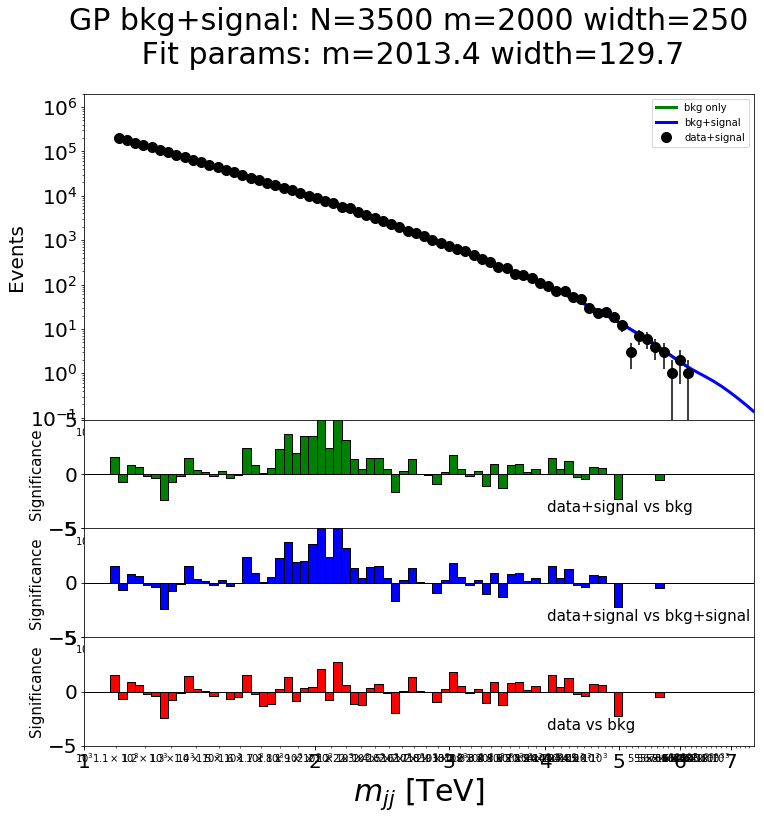

/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


chi2 nan


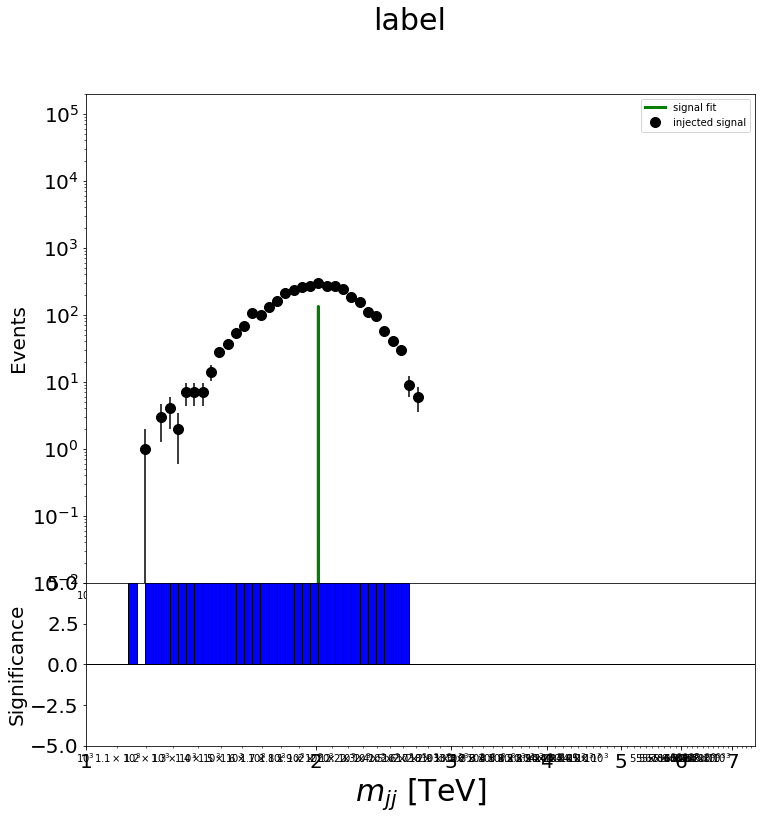

A, mass, tau 5999.999356 1915.72716579 114.490564994
A, mass, tau 5999.99999934 2396.01473843 127.682388141
A, mass, tau 5999.99978037 2279.81028078 54.7587821862
A, mass, tau 6000.0 1963.94179718 154.753572647
A, mass, tau 5999.99038763 2115.99161721 195.089480768
A, mass, tau 5999.99999998 1963.94180572 50.0004291533
A, mass, tau 6000.0 2064.04343082 105.323555483
A, mass, tau 5999.99999997 2169.24722104 54.4752327707
A, mass, tau 5999.99999608 2013.36972628 50.0004291533
10
A, mass, tau 6000.0 2169.24727614 68.6241232358
A, mass, tau 6000.0 2223.84318189 50.0004291533
A, mass, tau 6000.0 1915.72648708 62.2979336302
A, mass, tau 5999.98280829 2279.80981088 50.0004291533
A, mass, tau 5999.99943075 2279.81323223 70.7625964938
A, mass, tau 5998.63954057 2781.37431833 59.2474398532
A, mass, tau 5999.99999983 2279.8132227 85.2306127409
A, mass, tau 5999.9999999 2115.99160416 186.658111626
A, mass, tau 2122.56012064 3228.69613186 50.0004291533
A, mass, tau 5999.98968559 2279.8142472 185.35

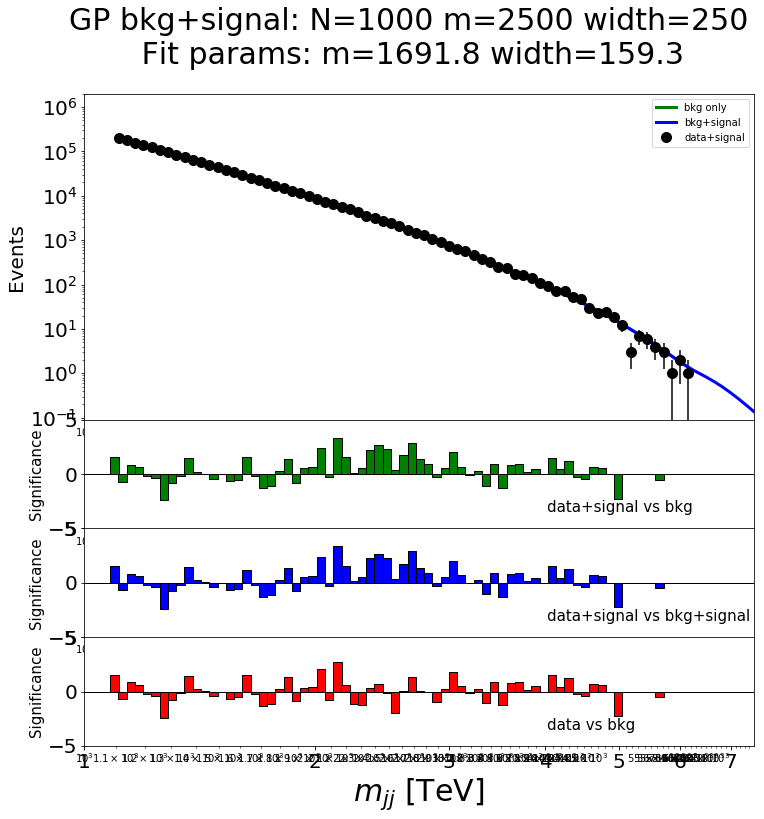

chi2 nan


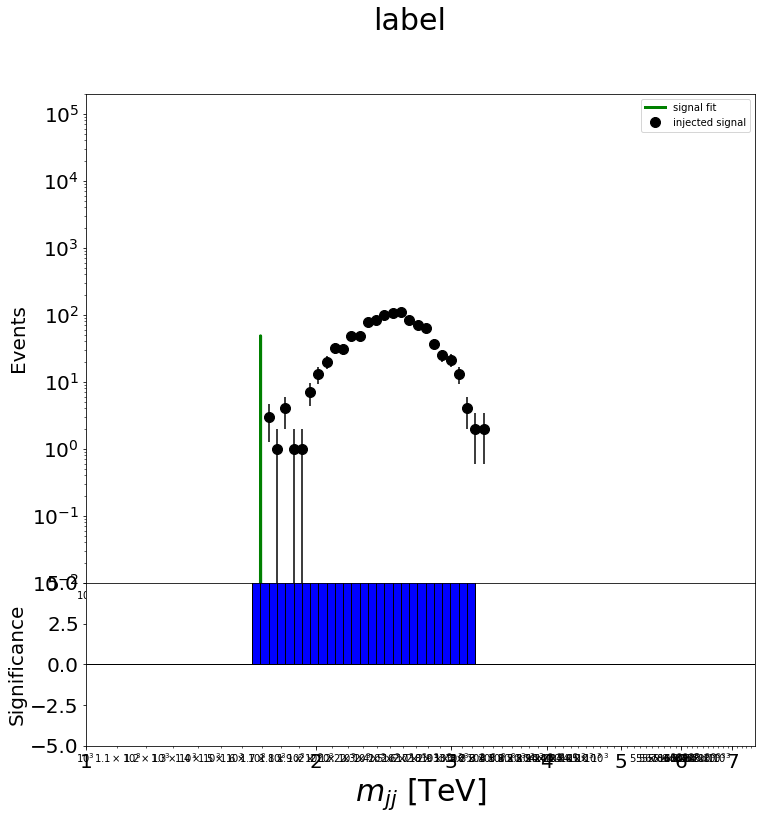

A, mass, tau 324.569720091 3842.86261147 186.631865804
A, mass, tau 2191.58575484 3477.69299727 116.678140739
A, mass, tau 5999.99945988 2851.38294334 50.0004291533
A, mass, tau 5999.99636106 2646.48796635 193.266159462
A, mass, tau 4947.20948399 2713.44549197 176.73287303
A, mass, tau 5999.99978006 2279.81496936 68.568705853
A, mass, tau 5999.95670802 2581.51259111 196.656743387
A, mass, tau 5464.06472776 2518.13374168 78.2800526472
A, mass, tau 5998.92874586 2713.09597332 191.995381373
10
A, mass, tau 2007.22760669 2922.87988186 163.786300792
A, mass, tau 5999.96587525 2396.01395334 180.273806356
A, mass, tau 5999.93509214 2713.09501134 140.060652535
A, mass, tau 5999.99999995 2337.19192815 196.38317596
A, mass, tau 2504.65133303 3309.99671601 116.742544152
A, mass, tau 5999.99966387 2337.18759201 58.9987591021
A, mass, tau 5999.9928735 2581.51528794 50.0004291533
A, mass, tau 5999.99998537 2781.3773988 71.4347854113
A, mass, tau 5999.84360341 2337.19055969 52.2585769514
A, mass, tau

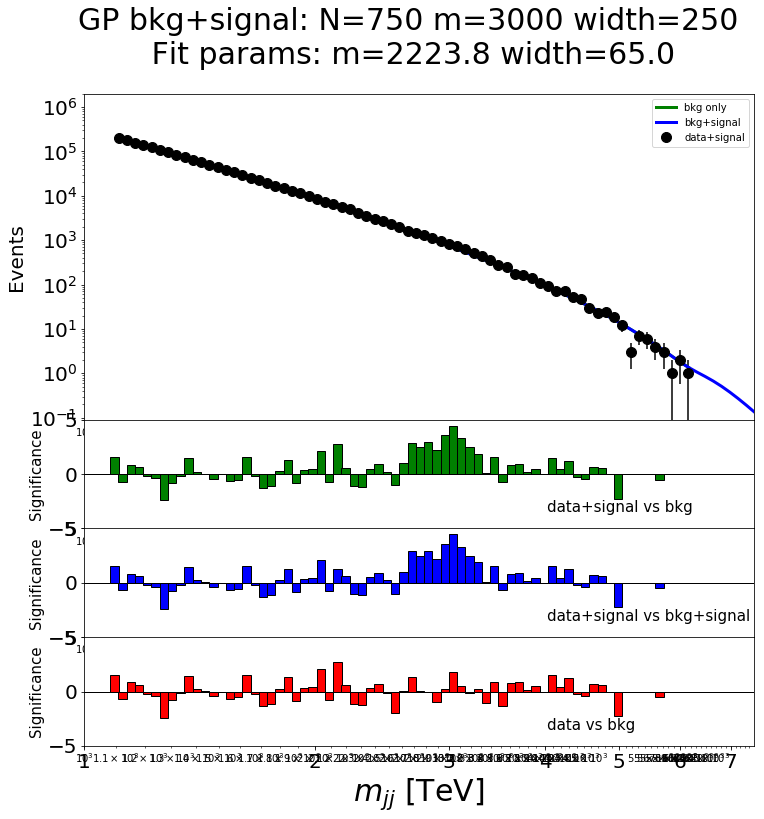

chi2 nan


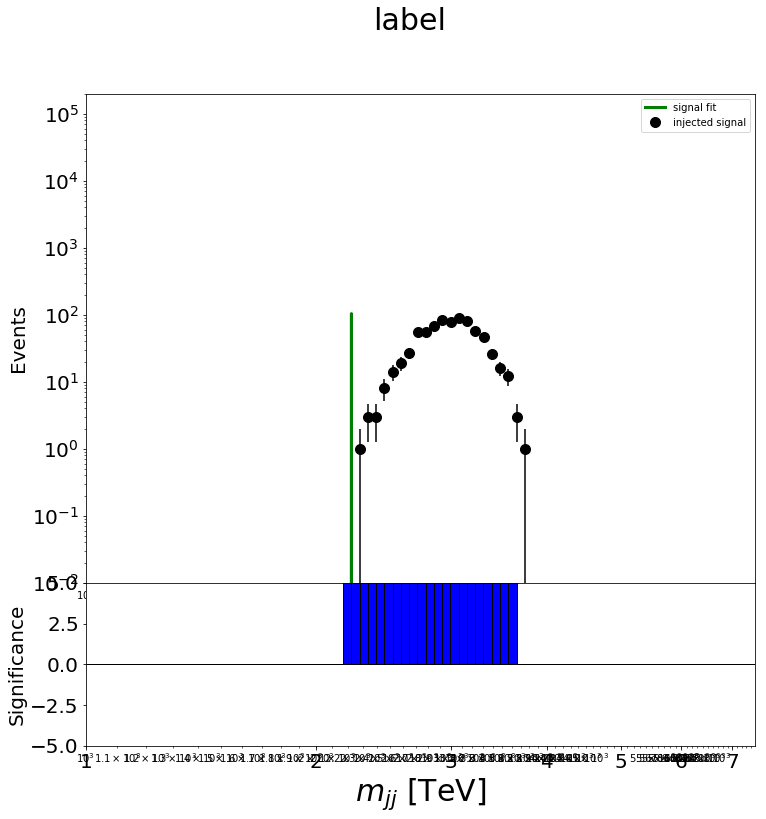

A, mass, tau 5999.999774 3149.45829954 50.0004291533
A, mass, tau 5996.52891771 3228.72543072 191.532390756
A, mass, tau 5998.2746596 3228.72315361 50.0004291533
A, mass, tau 5998.57192308 3149.48599793 95.1800156933
A, mass, tau 5985.23474186 3072.13699958 171.315771734
A, mass, tau 5999.82792289 3072.13796372 164.376742407
A, mass, tau 5999.96739549 3228.72079119 50.0004291533
A, mass, tau 4451.46948365 2852.04585153 187.663388224
A, mass, tau 6000.0 2996.71484045 191.686105494
10
A, mass, tau 5966.00140149 2995.9199443 89.8154171074
A, mass, tau 2965.66847886 3228.72289674 189.783331853
A, mass, tau 5999.99999998 1421.64836242 50.0004291533
A, mass, tau 5999.97972046 3228.72613843 180.549761557
A, mass, tau 2345.05403781 3071.98606554 150.117745357
A, mass, tau 5169.44446315 3071.3947294 169.428319406
A, mass, tau 6000.0 2923.14478975 170.586768234
A, mass, tau 5265.93723098 3393.50462978 139.530914138
A, mass, tau 4335.00415813 3478.1031727 50.0004291533
A, mass, tau 5999.99984838 

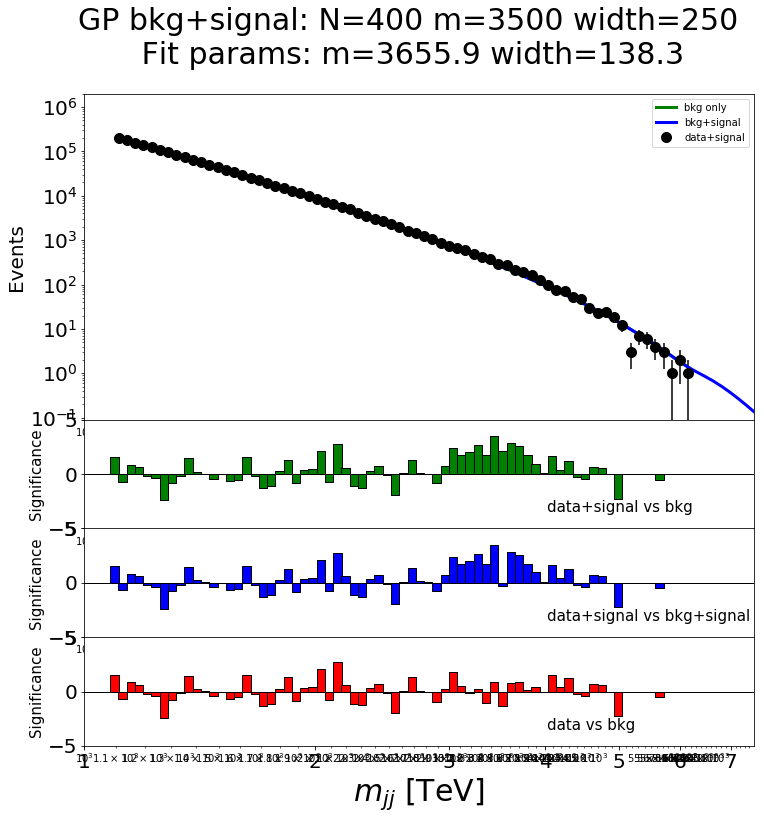

chi2 nan


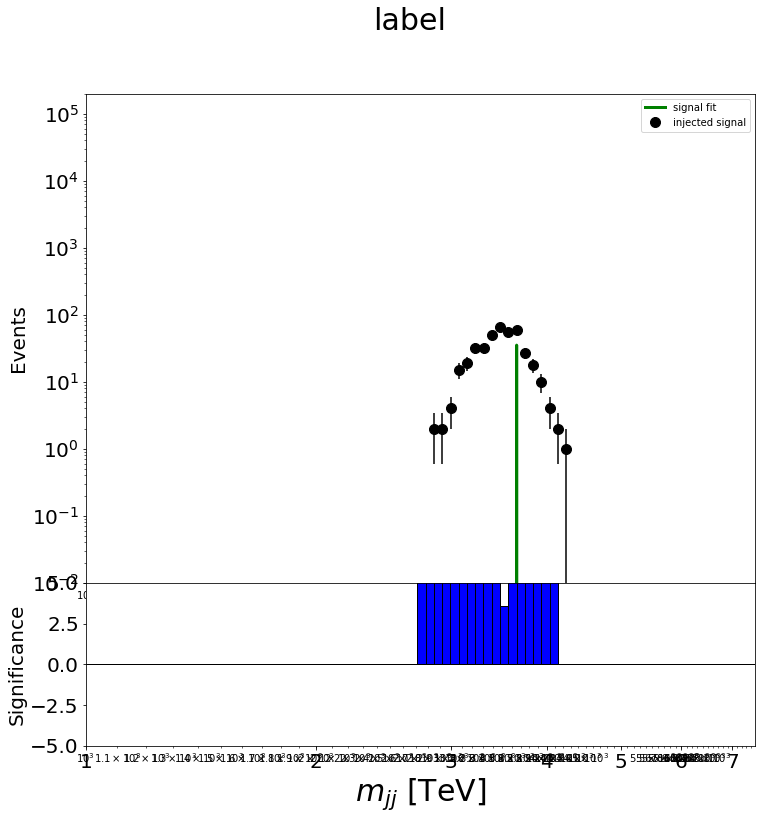

A, mass, tau 5998.77733595 3566.2328686 197.948335961
A, mass, tau 5999.99324972 3392.28405489 54.6414359692
A, mass, tau 5999.83318144 3309.18408516 140.13180814
A, mass, tau 465.785431433 3044.09689592 62.7983259259
A, mass, tau 5999.99730781 3746.61709205 194.302302902
A, mass, tau 5978.00413985 3148.43675412 57.2045567985
A, mass, tau 5999.99083528 3393.89528954 152.161471406
A, mass, tau 2578.51347788 3393.6957128 100.146873368
A, mass, tau 3526.08729851 2996.0802772 99.5643936554
10
A, mass, tau 5981.07250707 3748.32872585 143.877207449
A, mass, tau 5931.80502109 3656.68841888 134.694598699
A, mass, tau 3680.37434442 3566.13242257 135.227884255
A, mass, tau 2773.62327446 3656.00345451 50.0004291533
A, mass, tau 5999.99523 3309.99093037 113.650637518
A, mass, tau 6000.0 1691.83489407 50.0004291533
A, mass, tau 5999.99905059 3478.68380652 50.0004291533
A, mass, tau 2853.34564903 3566.87711891 139.645900958
A, mass, tau 5999.99999998 1494.10898402 65.9407158649
A, mass, tau 4775.907

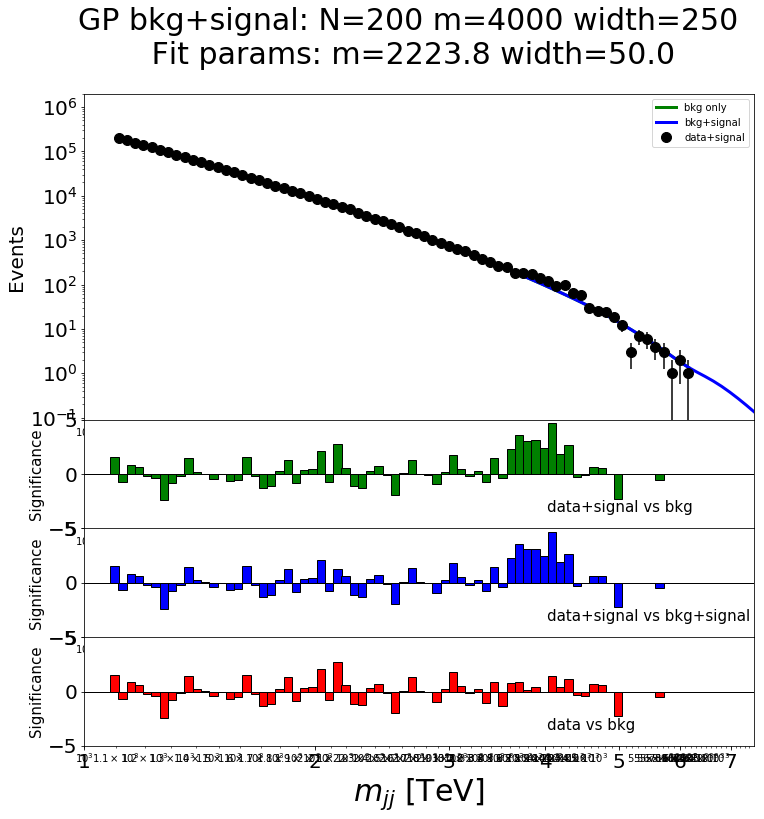

chi2 nan


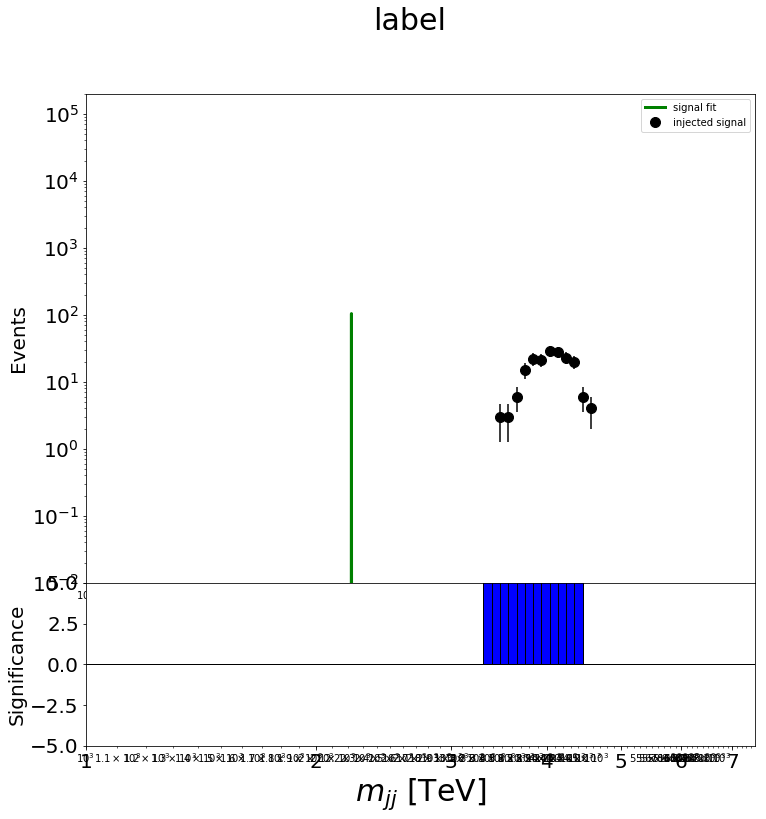

A, mass, tau 5998.83257478 3149.98431347 192.478161873
A, mass, tau 3482.8369856 3841.76592543 58.3608753942
A, mass, tau 5999.80054448 2279.81073518 52.7475205512
A, mass, tau 5999.99970965 2456.31802761 115.993398371
A, mass, tau 501.076206097 3938.54627022 137.309147251
A, mass, tau 1276.7445461 3842.4999792 60.2900865613
A, mass, tau 3999.64320398 3229.8483995 137.067486454
A, mass, tau 5999.99949425 2518.13993586 59.935614914
A, mass, tau 5999.67487403 2013.37199844 176.14305396
10
A, mass, tau 568.670055318 3228.53288759 143.411898244
A, mass, tau 4418.68243829 3749.27537728 50.0004291533
A, mass, tau 6000.0 1778.06408594 107.35005767
A, mass, tau 2664.84640378 3938.45712587 176.891426526
A, mass, tau 2489.88059633 3309.98391856 61.2132330825
A, mass, tau 5997.33358126 2064.03070666 176.242121836
A, mass, tau 2221.84565318 3842.01567423 85.8067274474
A, mass, tau 1992.12942577 3939.02861953 192.696382742
A, mass, tau 5999.99999994 1778.06714824 64.5234883195
A, mass, tau 5999.842

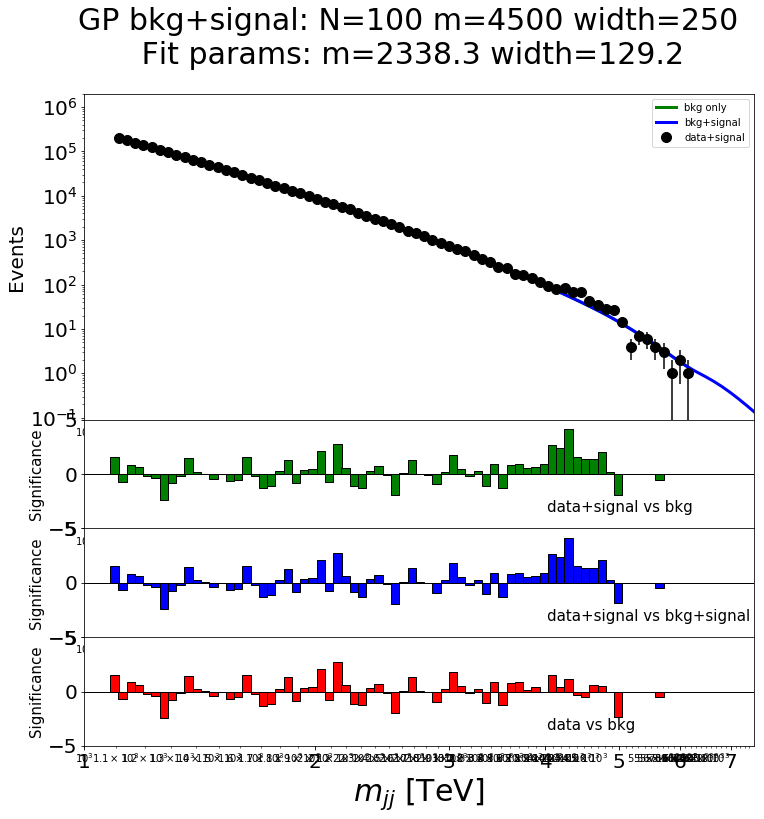

chi2 nan


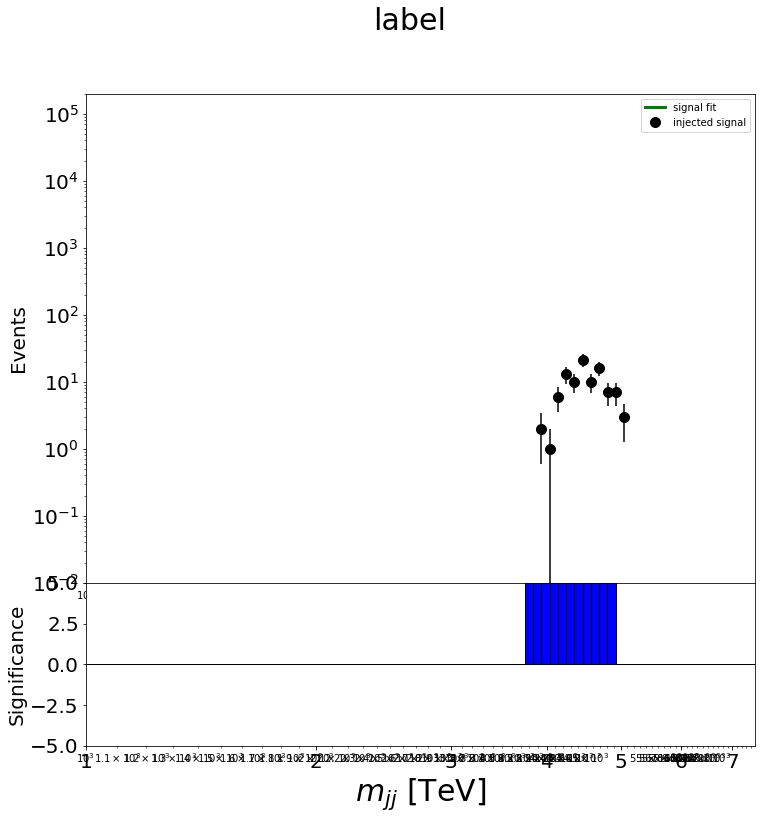

A, mass, tau 4595.22932537 3149.3960872 50.0004291533
A, mass, tau 4009.27412458 2581.51551754 50.0004291533
A, mass, tau 5998.75766312 2456.310903 118.180231816
A, mass, tau 5999.99978584 3070.82597642 129.781698903
A, mass, tau 1205.14204546 3566.11961388 50.6573211615
A, mass, tau 2053.2257696 3567.55102927 178.982940356
A, mass, tau 5999.50344247 2456.312169 78.5705092317
A, mass, tau 1190.97947806 3149.44814725 104.294884981
A, mass, tau 5999.99689634 1822.81870908 148.804279908
10
A, mass, tau 559.286322741 3228.71019568 99.537659826
A, mass, tau 4933.29587242 3750.44334358 166.623715027
A, mass, tau 5999.99999996 1255.49979386 50.0004291533
A, mass, tau 5195.40817199 3937.14852899 50.0004291533
A, mass, tau 3351.55809168 2923.4107925 160.074810802
A, mass, tau 6000.0 1531.71343057 50.0004291533
A, mass, tau 2175.1247148 3310.16839406 51.1441595408
A, mass, tau 5973.29270894 2456.33480002 182.798780734
A, mass, tau 5999.99982122 1778.06790066 50.0004291533
A, mass, tau 5999.93785

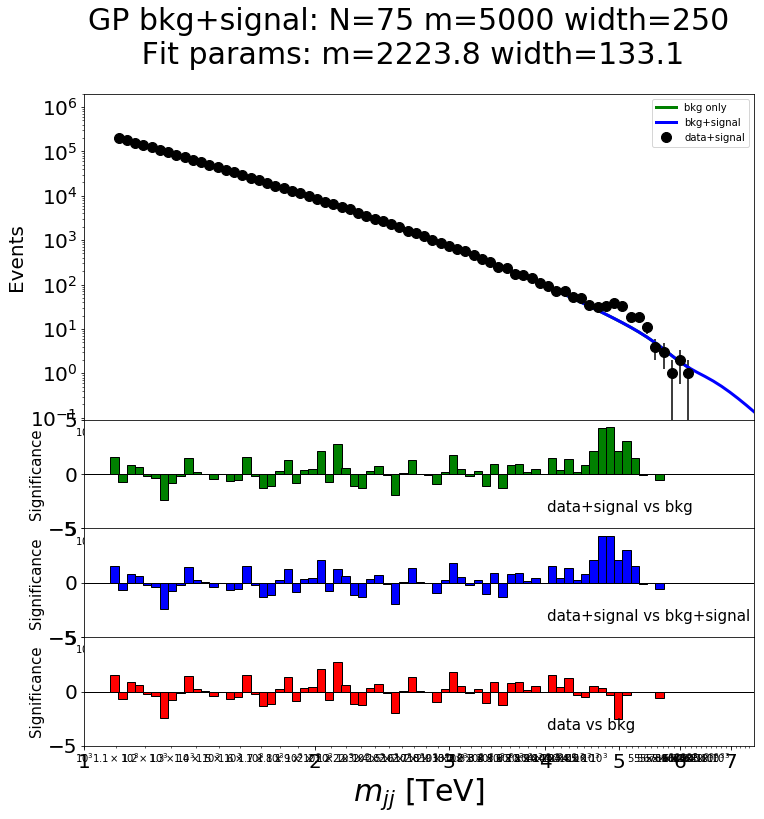

chi2 nan


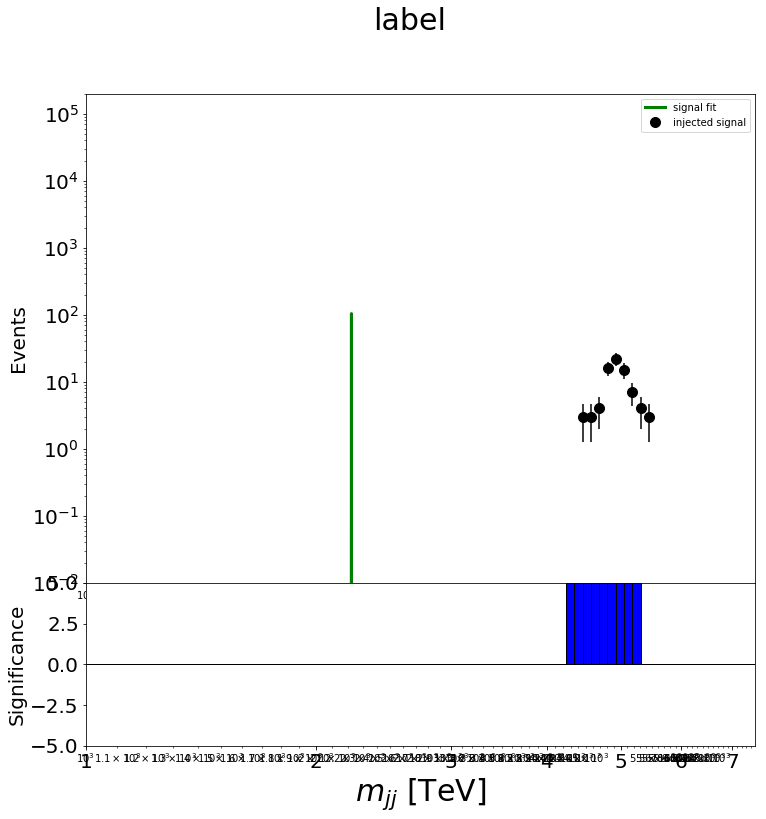

A, mass, tau 5991.54161455 3149.97894246 66.1822845385
A, mass, tau 802.606937362 3478.71566454 132.147909937
A, mass, tau 110.847293111 3228.70627389 170.721229117
A, mass, tau 306.539494585 3748.50157693 50.0004291533
A, mass, tau 5999.81352401 3150.5037477 106.316170915
A, mass, tau 5999.99903859 2064.0434231 73.486150564
A, mass, tau 5999.99999842 1352.70133819 50.0004291533
A, mass, tau 6000.0 2518.13907793 150.487278147
A, mass, tau 364.153803108 3939.47759083 50.0004291533
10
A, mass, tau 5999.9999922 1915.71591503 132.936675663
A, mass, tau 5398.15196779 2851.60246297 50.0004291533
A, mass, tau 3164.1385342 2850.15030556 126.686077587
A, mass, tau 5999.94305656 1868.68688611 50.0004291533
A, mass, tau 3421.54551219 2923.68687285 179.004341137
A, mass, tau 5999.99999996 2064.04333193 186.784088666
A, mass, tau 2103.89075114 3310.04124335 50.0004291533
A, mass, tau 6000.0 1868.69487464 50.0004291533
A, mass, tau 6000.0 1778.06729277 140.63010679
A, mass, tau 5842.66593405 2337.19

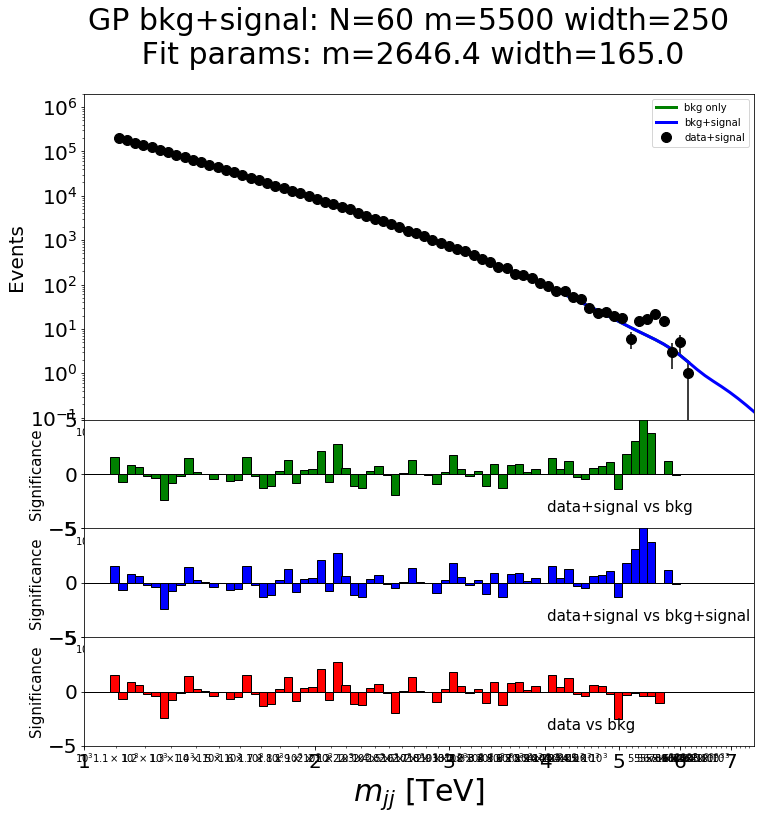

chi2 nan


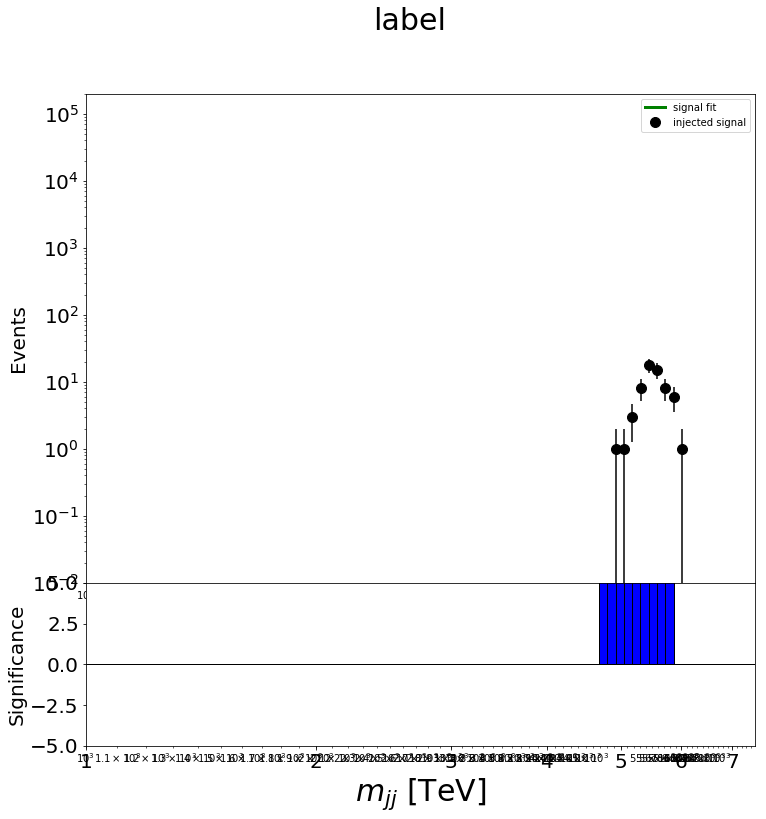

A, mass, tau 436.383555997 1885.09000121 137.532062223
A, mass, tau 5639.27205539 3477.29856452 134.085115887
A, mass, tau 5724.62995961 2851.17473149 50.0004291533
A, mass, tau 5999.99999998 2456.32016568 170.537319122
A, mass, tau 103.536988868 3749.43939008 86.2005222255
A, mass, tau 1114.87622161 3149.44550448 82.8633229396
A, mass, tau 5979.60002091 2852.64093146 113.534213988
A, mass, tau 2189.9525568 3937.32397481 50.0004291533
A, mass, tau 3185.40467722 2851.1284535 50.0004291533
10
A, mass, tau 6000.0 1319.49272797 50.0004291533
A, mass, tau 5999.99152608 2646.48602596 50.0004291533
A, mass, tau 5999.96102467 2781.37286118 126.206855474
A, mass, tau 3136.84887405 2782.45991395 124.325903204
A, mass, tau 5999.99999959 1287.09845355 188.182008517
A, mass, tau 5998.83915905 2781.37949502 94.8237810357
A, mass, tau 5999.99999992 1386.74651228 188.18412453
A, mass, tau 5999.98377203 2013.37058341 84.9068076835
A, mass, tau 3114.15404473 3228.10556014 113.761838353
A, mass, tau 4445

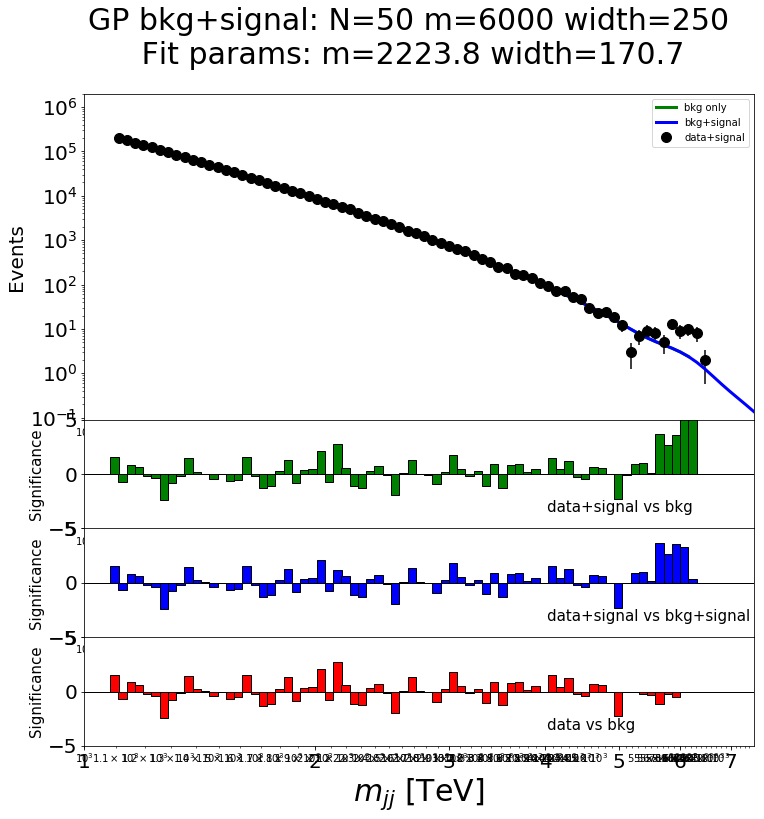

chi2 nan


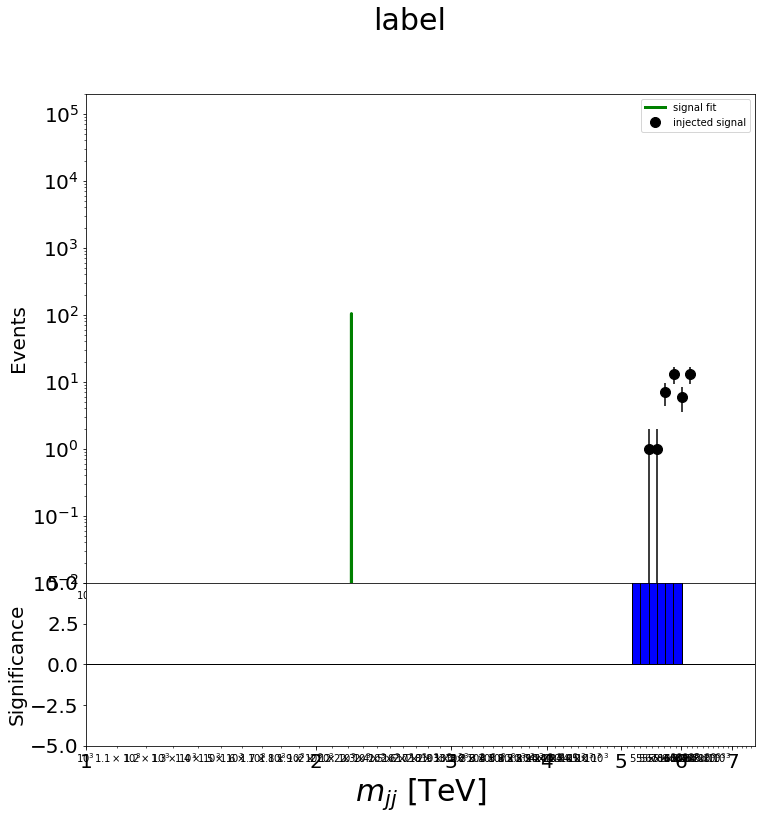

A, mass, tau 2790.78444953 3840.79130568 50.0004291533
A, mass, tau 4494.59544631 2581.83872185 191.976083429
A, mass, tau 5998.93372979 2456.32112358 111.095998753
A, mass, tau 1309.26299815 4037.16592024 50.0004291533
A, mass, tau 2018.88979333 3149.44091085 77.0949591326
A, mass, tau 4445.91386255 3150.63282931 77.7106377988
A, mass, tau 5999.99999427 1570.26405102 62.9919225803
A, mass, tau 5999.99822972 2396.01514608 55.5346395952
A, mass, tau 4401.00729098 3227.5298829 163.778599426
10
A, mass, tau 5244.14094002 3749.47500145 146.32733319
A, mass, tau 5999.96874802 2646.47893664 164.829010225
A, mass, tau 5999.92054005 2279.81037246 144.196796041
A, mass, tau 3543.28920178 3311.78025897 50.0004291533
A, mass, tau 3634.70097318 2923.7402035 50.0004291533
A, mass, tau 2224.64856773 3228.69693724 123.226727163
A, mass, tau 5999.99589002 1386.73564562 50.0004291533
A, mass, tau 6000.0 2013.37076805 72.928285556
A, mass, tau 2434.35076476 3479.39684974 50.0004291533
A, mass, tau 4707.

In [25]:
#Set of amplitude, mean, and sigma for each Gaussian signal to be injected
standardParamSets = [(3500,2000,250), (1000 ,2500, 250),(750, 3000, 250), (400, 3500, 250), (200, 4000, 250), 
             (100, 4500, 250), (75, 5000, 250), (60,5500, 250), (50, 6000,250)] 

aa={}
mm={}
ww={}
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]
    for itoy, toy in enumerate(toyData[:20]): 
        if itoy%10 ==0: print itoy
        
        #remove any zero bins 
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        #create a fake signal and add some noise to it
        signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
        signalTemplate = np.random.poisson(np.around(signalTemplate))
        signalTemplate_full = sig_model(xbins, n, m, w, xerrs)
        signalTemplate_full = np.random.poisson(np.around(signalTemplate_full))
        
        #new bkg+signal pseudodata
        ydata =  ytoy + signalTemplate
        ydata_full =  toy + signalTemplate_full
        
        #fit signal GP
        Amp, lengthscale, p0, p1, p2 = fixedHyperparameters
        lnProb = logLike_gp_fitgpsig(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau

        #get the final bkg, signal, and signal+bkg GP predictions
        hyperParams = list(fixedHyperparameters)+list(best_fit_new)
        MAP_GP, MAP_bkg, MAP_sig = runGP_SplusB(ydata, xtoy, xtoyerr, xbins, xerrs, hyperParams)
        
        #add zero bins back in
        newy, newx = addZeros(MAP_bkg, xtoy)
        
        #make some pretty plots
        if itoy%50 ==0:
            label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
            makePrettyPlots_sb(xtoy, xbins, toy, ydata_full, newy, MAP_bkg, MAP_GP, binEdges, label)
            makePrettyPlots_signalOnly(xtoy, signalTemplate, MAP_sig, "label")

        

### check how well the GP signal is centered at the correct mass across all toys

In [33]:
for pSet in standardParamSets:
    n, m, w = pSet
    print "mass", m
    print "mean predicted mass", np.mean(mm[m])
    print "mean predicted width", np.mean(ww[m])
    #print "predicted width", ww[m]

mass 2000
mean predicted mass 2222.4793946657223
mean predicted width 95.22025591125478
mass 2500
mean predicted mass 2640.53720903708
mean predicted width 129.9604029398185
mass 3000
mean predicted mass 3008.230077922928
mean predicted width 126.40184580831274
mass 3500
mean predicted mass 3273.496717513967
mean predicted width 111.85396379685533
mass 4000
mean predicted mass 3013.5807996392214
mean predicted width 107.60194357546922
mass 4500
mean predicted mass 2786.0885746718645
mean predicted width 97.88886286853959
mass 5000
mean predicted mass 2631.1248647707835
mean predicted width 101.51789461063096
mass 5500
mean predicted mass 2661.6043921407822
mean predicted width 105.50574652386904
mass 6000
mean predicted mass 2840.1243228493636
mean predicted width 103.08848102505131


### What about other signal shapes?
#### try different shapes that are smeared out i.e. a square

#### smearing function - convolute your signal with a Gaussian to smear it out, and add some Poisson noise to get a fake signal

In [16]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 100)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smear(s, signal_shape, xb):
    smeared_counts=np.zeros(len(xb))
    for xi, x in enumerate(xb):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [17]:
def square(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width: output[i]=amp
    return output

parameters (300, 2000, 250)
0
A, mass, tau 5999.99999999 2064.04340513 50.0004291533


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 168.8236602446276
chi2 bkg+signal nan


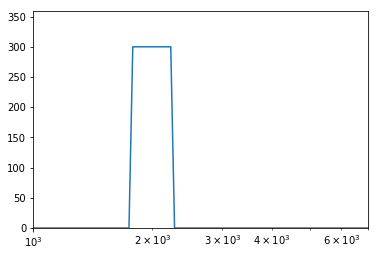

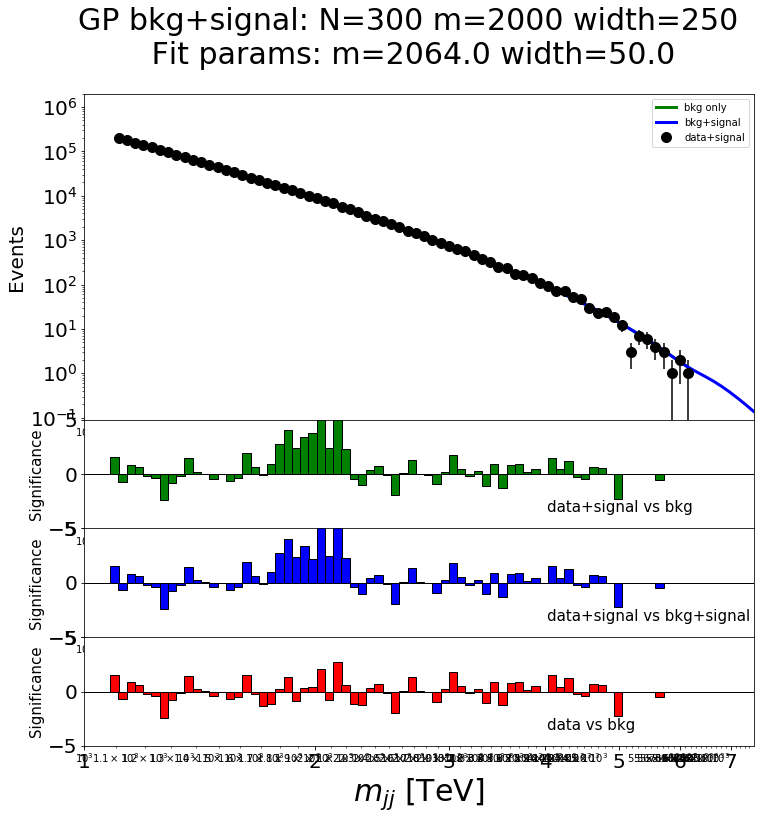

/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


chi2 nan


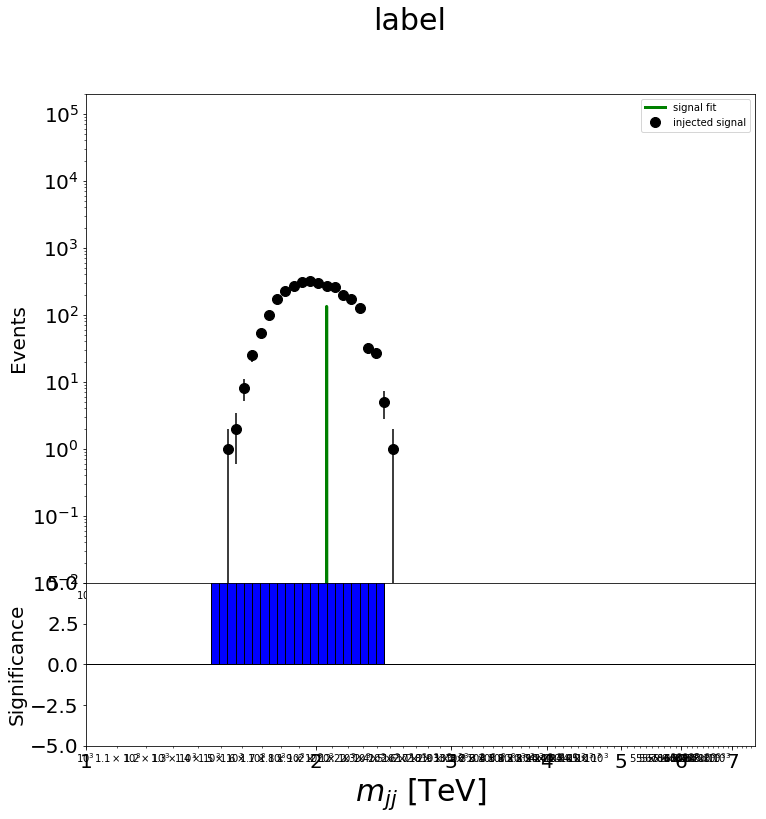

parameters (200, 2500, 250)
0
A, mass, tau 5999.99999415 2713.09519829 50.0004291533
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 158.96280147245727
chi2 bkg+signal nan


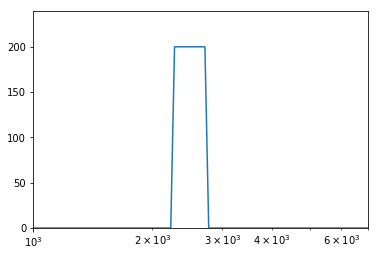

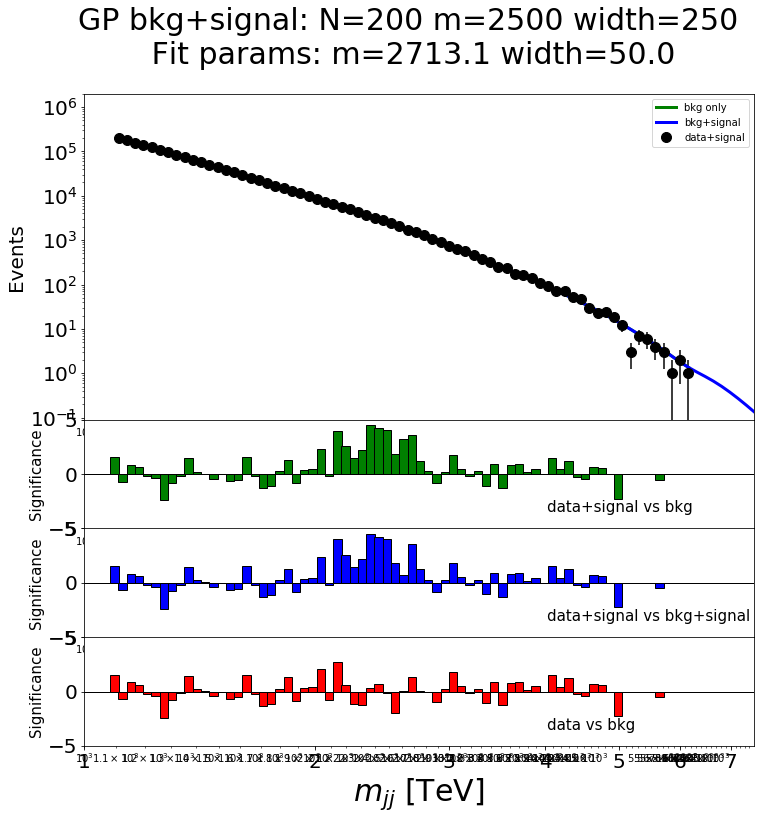

chi2 nan


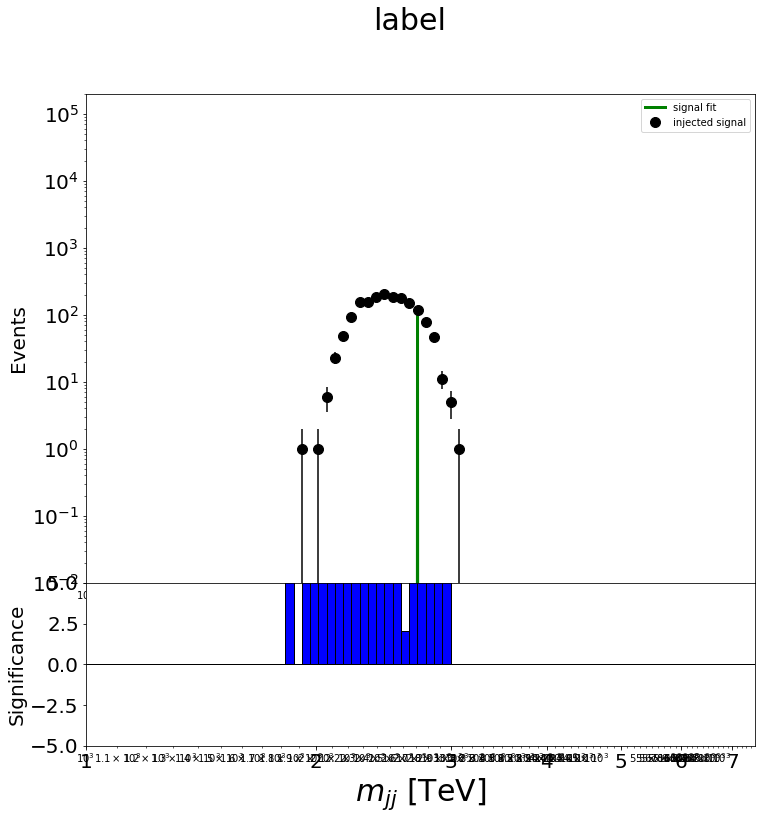

parameters (100, 3000, 250)
0
A, mass, tau 5999.99507876 3072.13128475 50.0004291533
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 141.31692225776274
chi2 bkg+signal nan


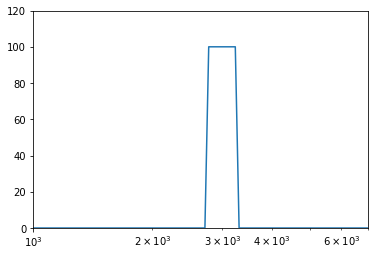

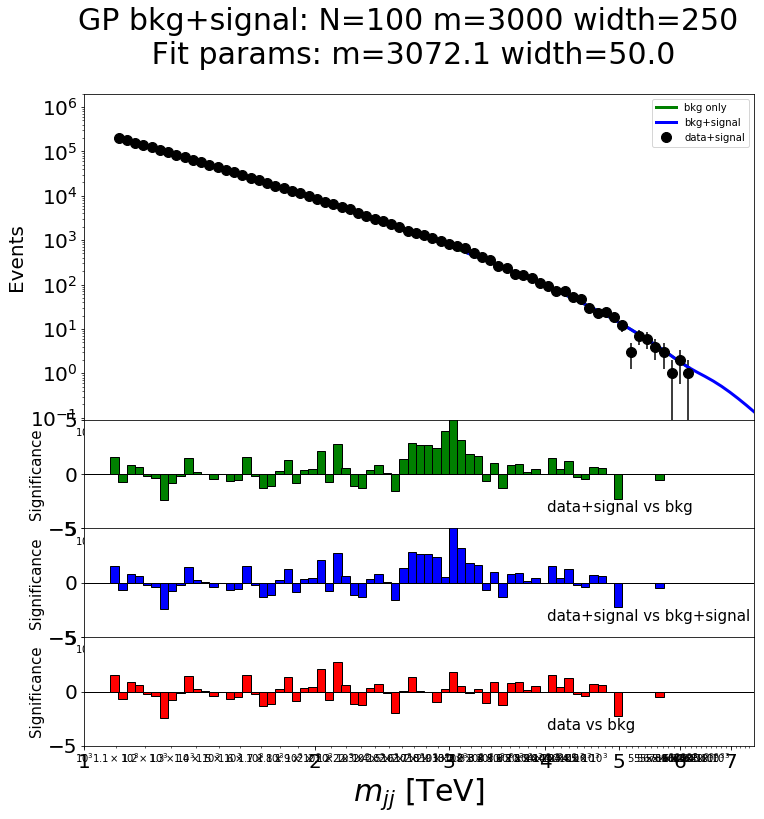

chi2 nan


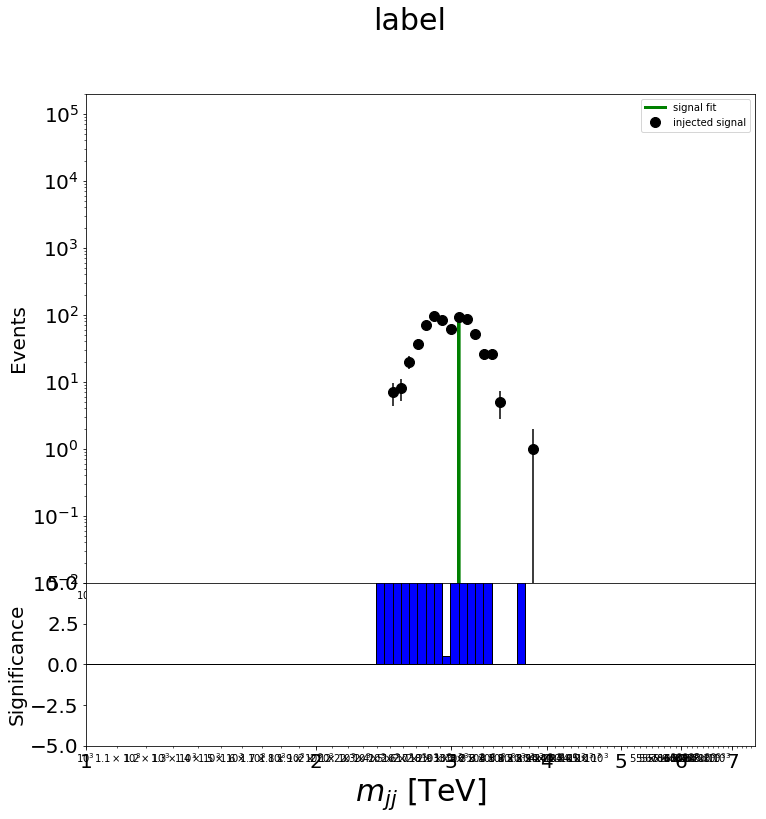

parameters (75, 3500, 250)
0
A, mass, tau 3765.70336244 3309.66861856 79.8348441738
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 154.38038375004757
chi2 bkg+signal nan


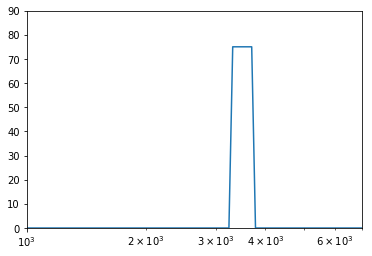

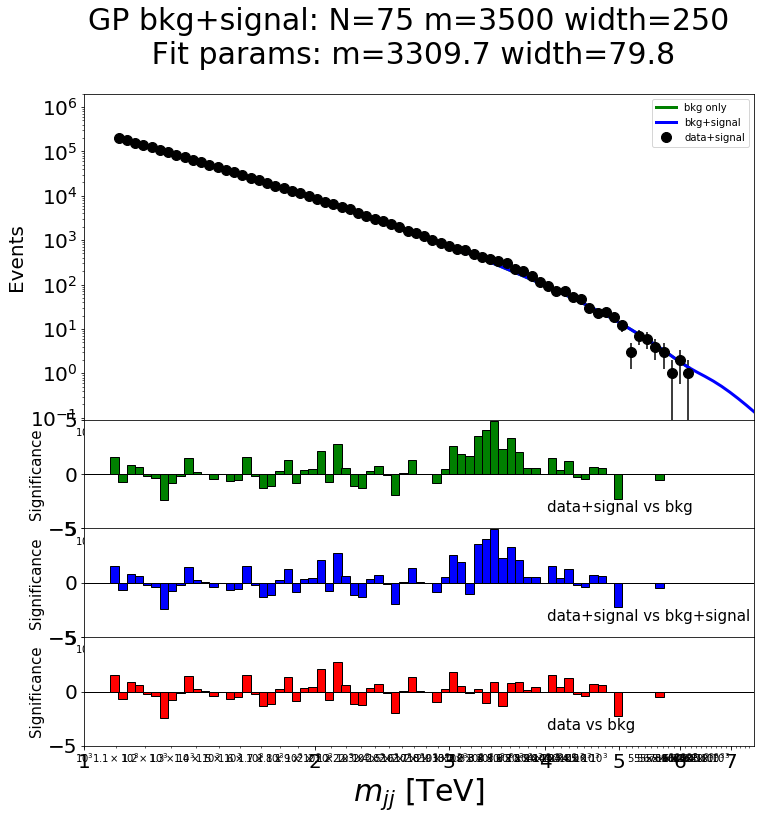

chi2 nan


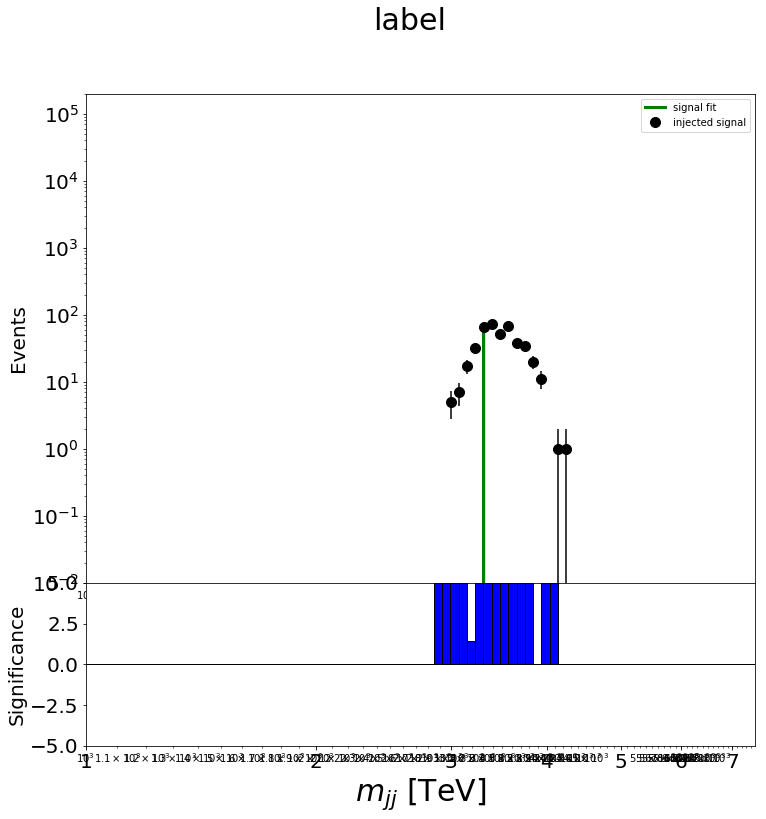

parameters (65, 4000, 250)
0
A, mass, tau 3675.5481453 3842.17041382 93.3534119592
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 234.80917449411373
chi2 bkg+signal nan


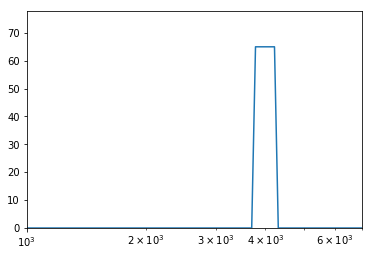

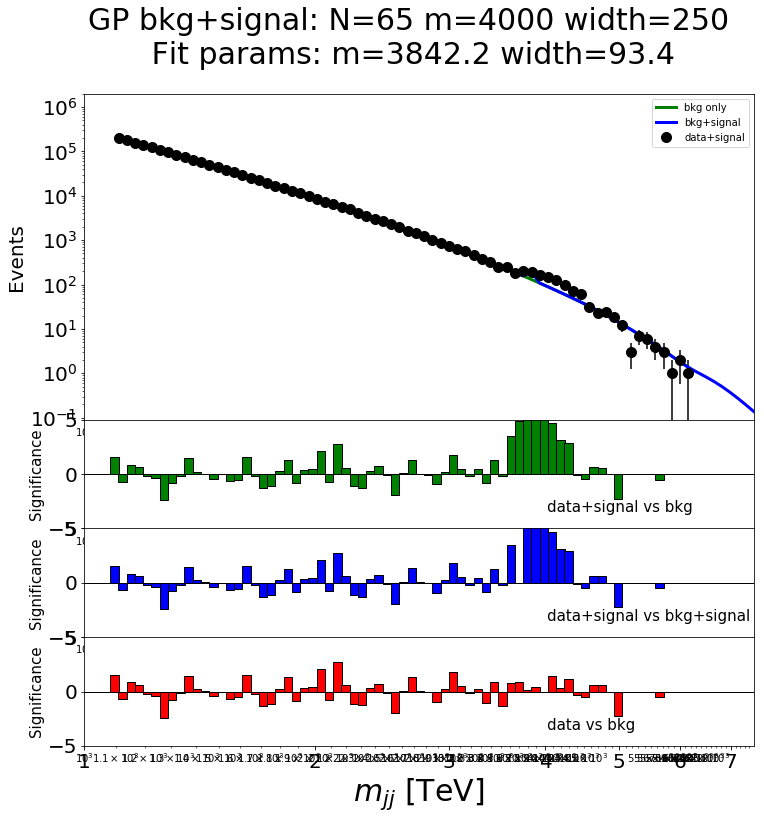

chi2 nan


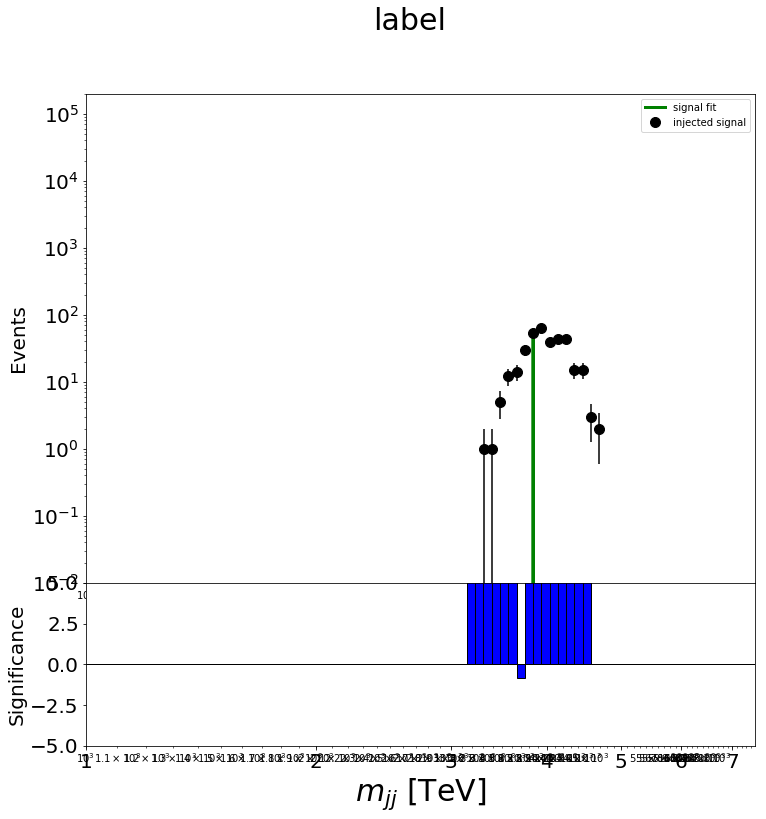

parameters (50, 4500, 250)
0
A, mass, tau 5999.99903175 2115.99032862 50.0004291533
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 293.17449957083613
chi2 bkg+signal nan


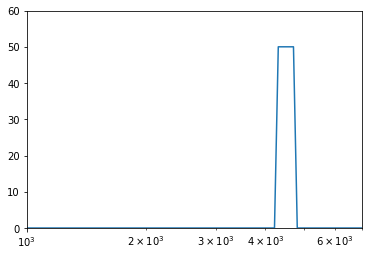

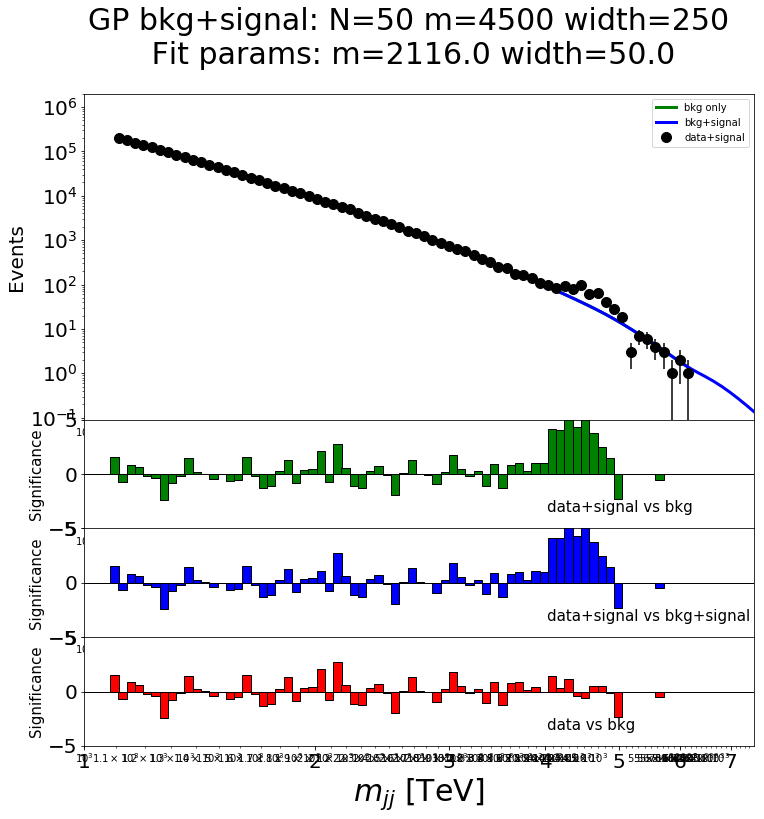

chi2 nan


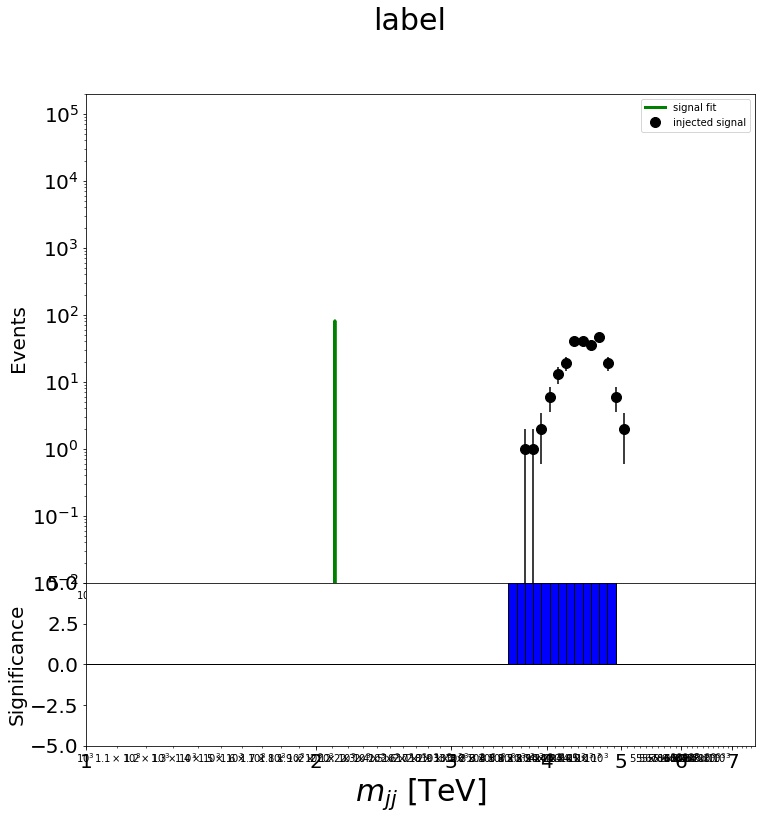

parameters (40, 5000, 250)
0
A, mass, tau 6000.0 2223.84318189 199.628255789
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 227.90929084624364
chi2 bkg+signal nan


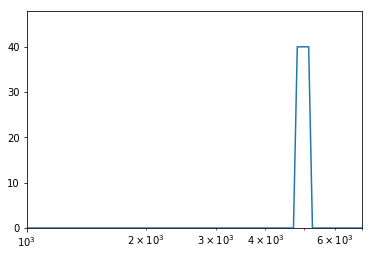

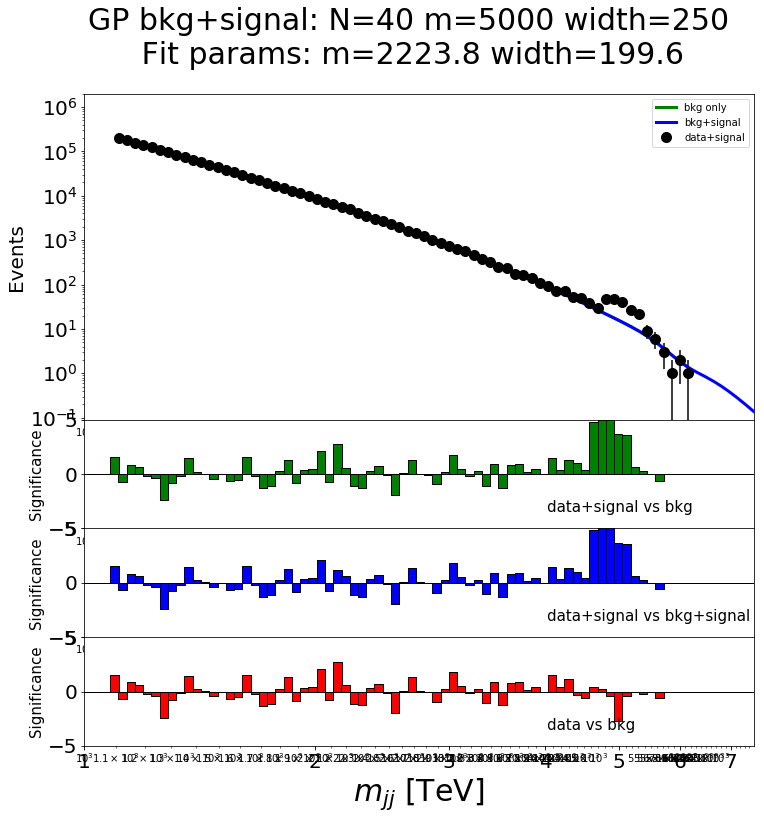

chi2 nan


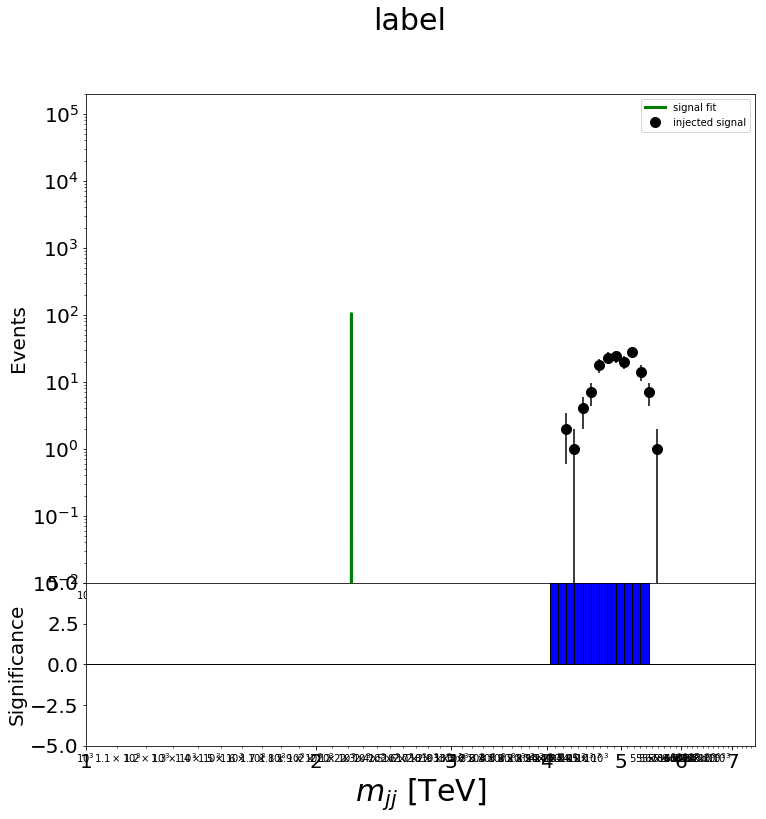

parameters (20, 5500, 250)
0
A, mass, tau 1281.05503282 3149.19700067 62.9916137602
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 233.92807702479234
chi2 bkg+signal nan


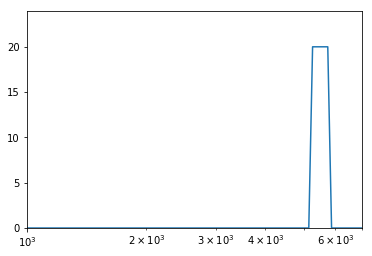

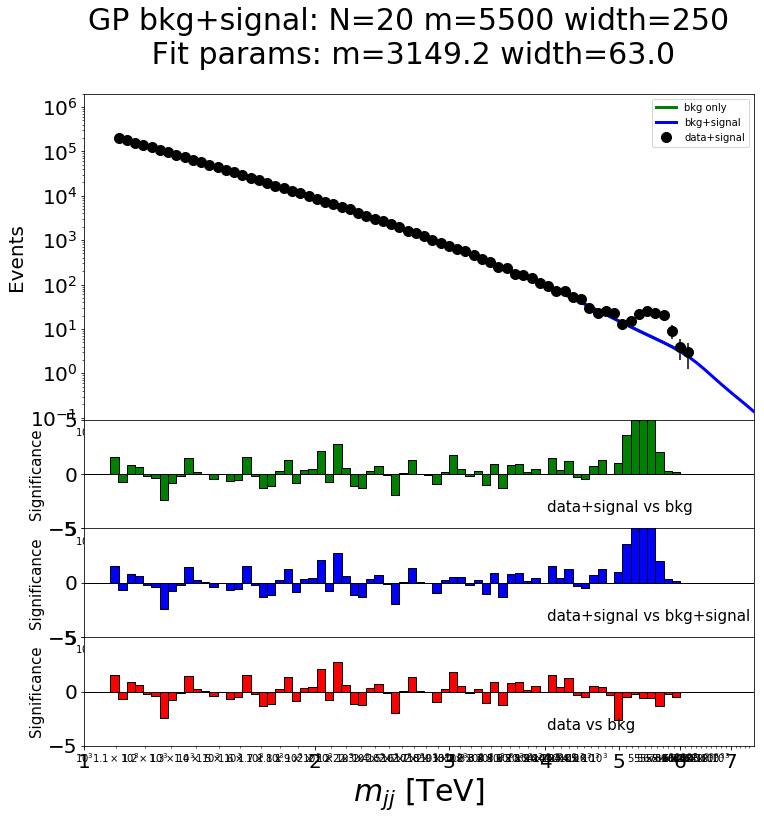

chi2 nan


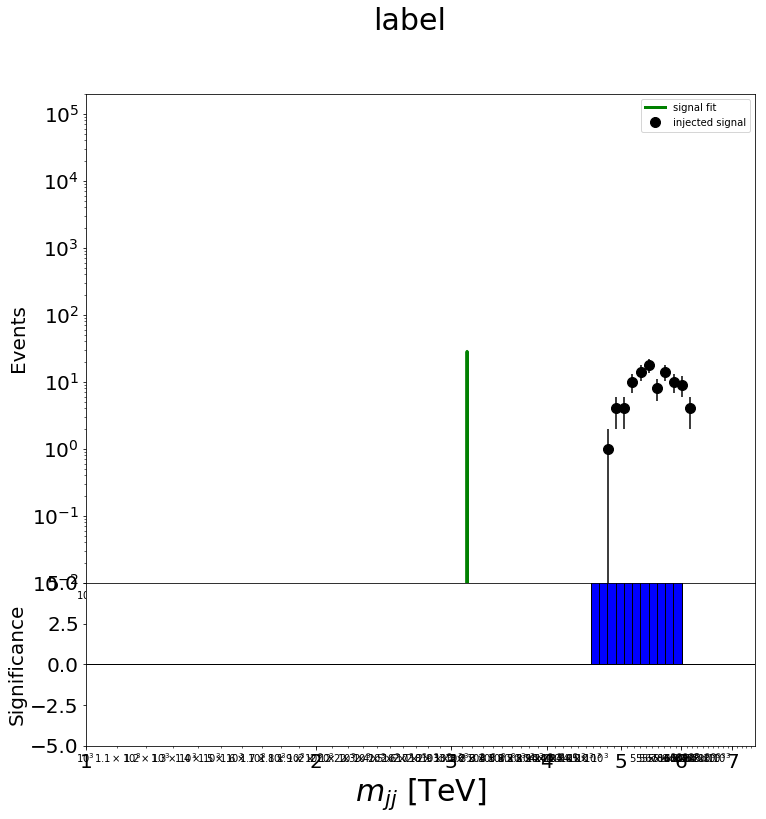

parameters (10, 6000, 250)
0
A, mass, tau 4707.358654 2646.5734104 100.091108942
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 79.75146202245492
chi2 bkg+signal nan


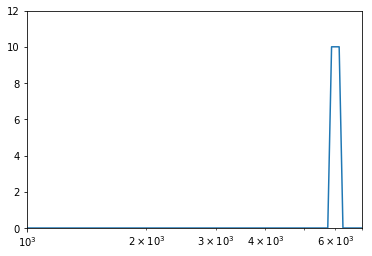

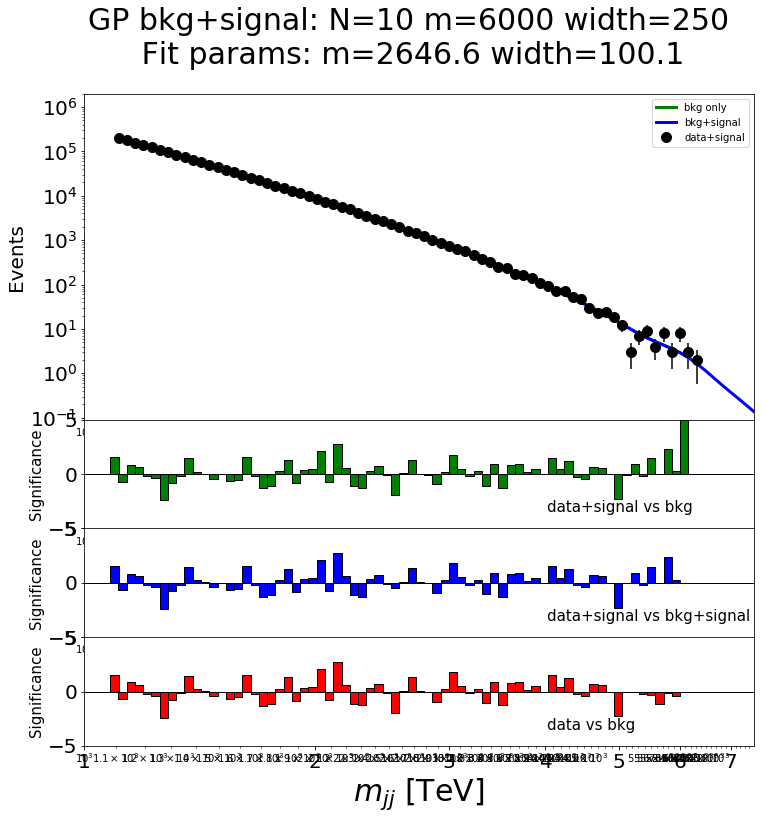

chi2 nan


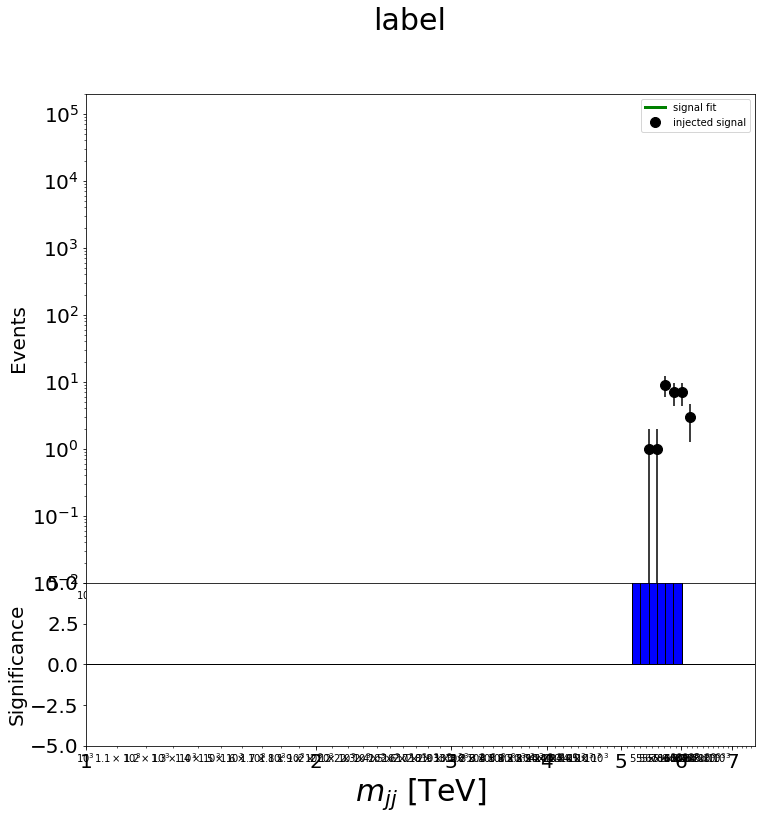

In [19]:
import scipy.stats as ss
standardParamSets = [(300,2000,250), (200 ,2500, 250),(100, 3000, 250), (75, 3500, 250), (65, 4000, 250), 
             (50, 4500, 250), (40, 5000, 250), (20,5500, 250), (10, 6000,250)]

aa={}
mm={}
ww={}
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]
    for itoy, toy in enumerate(toyData[:1]): 
        if itoy%10 ==0: print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)
        smeared_counts, signalTemplate = smear(np.zeros(len(truth_steps)), signal, xtoy)
        smeared_countsO, signalTemplate_full = smear(np.zeros(len(truth_steps)), signal, xbins)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.xscale('log')
        plt.ylim([0, float(n)*1.2])
        
        
        ydata =  ytoy + signalTemplate
        ydata_full =  toy + signalTemplate_full
        
        Amp, lengthscale, p0, p1, p2 = fixedHyperparameters
        lnProb = logLike_gp_fitgpsig(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        
        hyperParams = fixedHyperparameters + best_fit_new
        MAP_GP, MAP_bkg, MAP_sig = runGP_SplusB(ydata, xtoy, xtoyerr, xbins, xerrs, hyperParams)
        
        newy, newx = addZeros(MAP_bkg, xtoy)
   

        label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
        makePrettyPlots_sb(xtoy, xbins, toy, ydata_full, newy, MAP_bkg, MAP_GP, binEdges, label)
        makePrettyPlots_signalOnly(xtoy, signalTemplate, MAP_sig, "label")



#### try a sharp peak

In [179]:
def peak(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    slope=0.5
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center: 
            output[i]=(slope*c-slope*center+amp)
        if c > center and c < center+width:
            output[i]=(-slope*c+slope*center+amp)
    output = [s if s > 0 else 0 for s in output]
    return output

parameters (300, 2000, 250)
0
A, mass, tau 5999.99999924 2027.61489187 162.905275345


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 82.288062823
chi2 bkg+signal nan


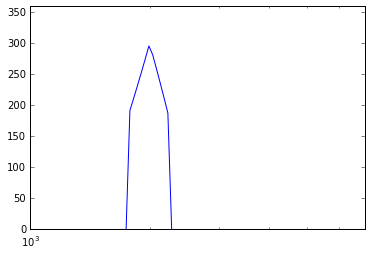

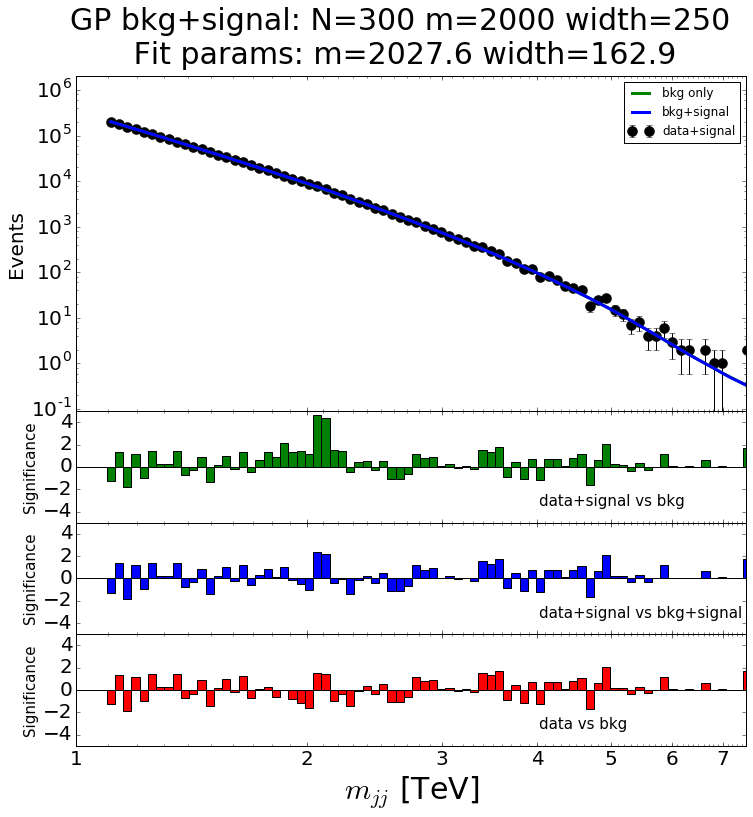

chi2 429.524692823


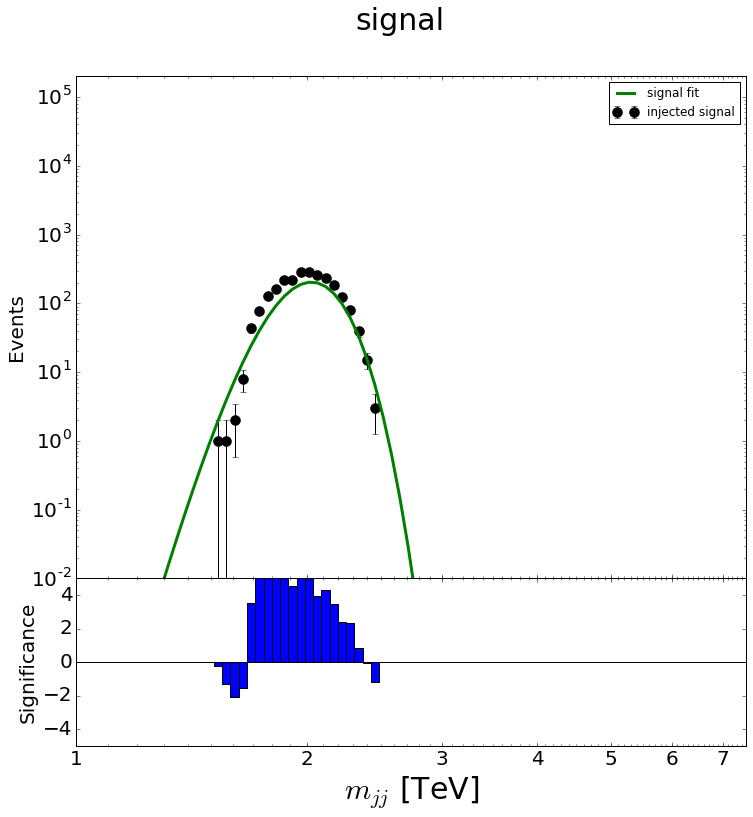

parameters (200, 2500, 250)
0
A, mass, tau 5999.99999997 2528.21537367 206.525283173
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 80.1080191026
chi2 bkg+signal nan


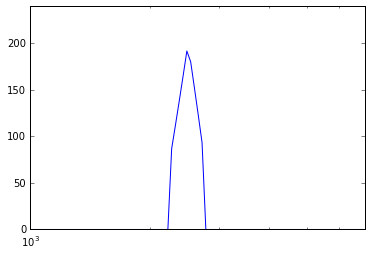

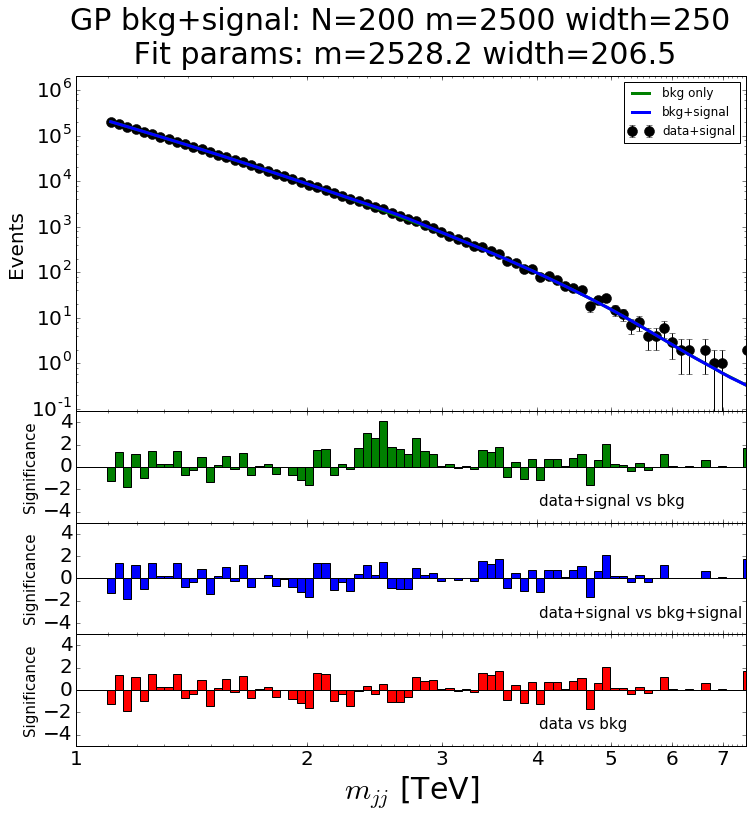

chi2 110.658816435


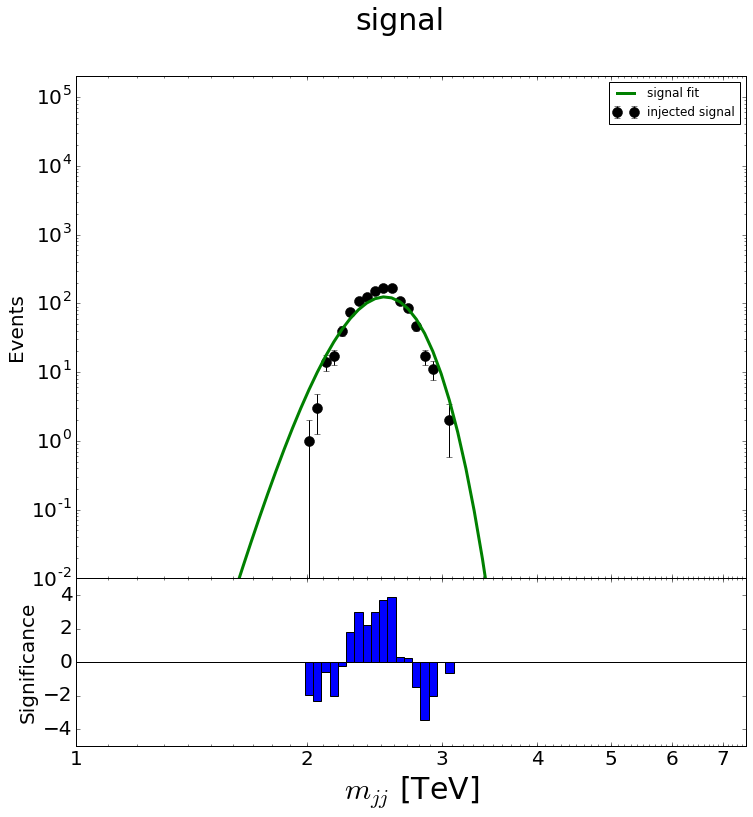

parameters (150, 3000, 250)
0
A, mass, tau 5999.9999994 2981.75846553 191.859816609
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 79.3757385451
chi2 bkg+signal nan


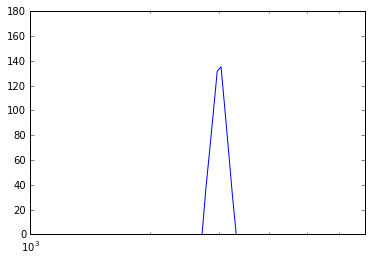

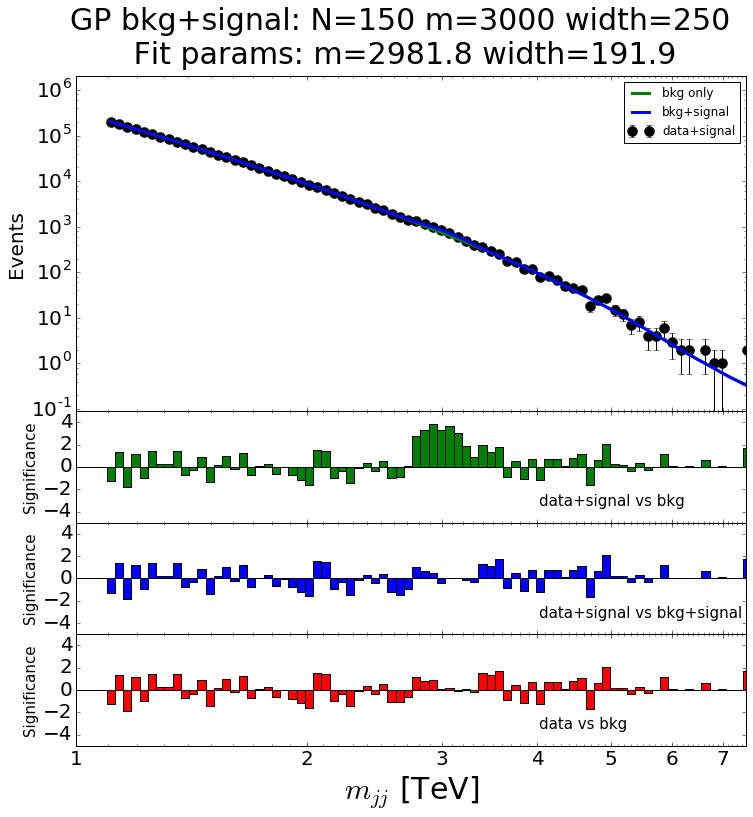

chi2 32.7029171143


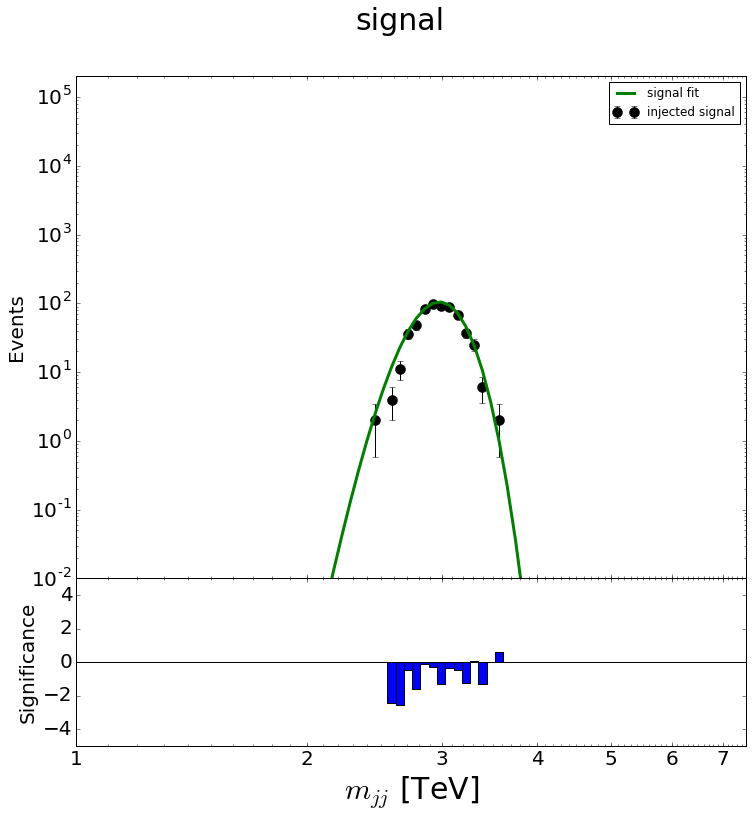

parameters (100, 3500, 250)
0
A, mass, tau 4712.62738441 3484.73633634 127.237155429
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 73.8953971006
chi2 bkg+signal nan


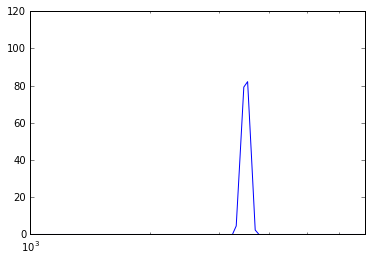

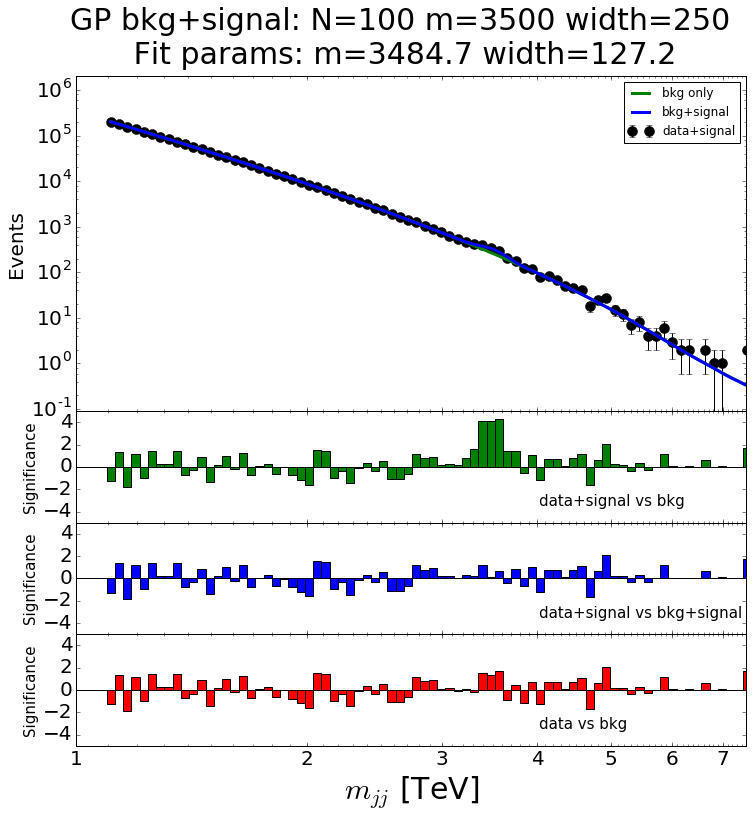

chi2 1811.95087763


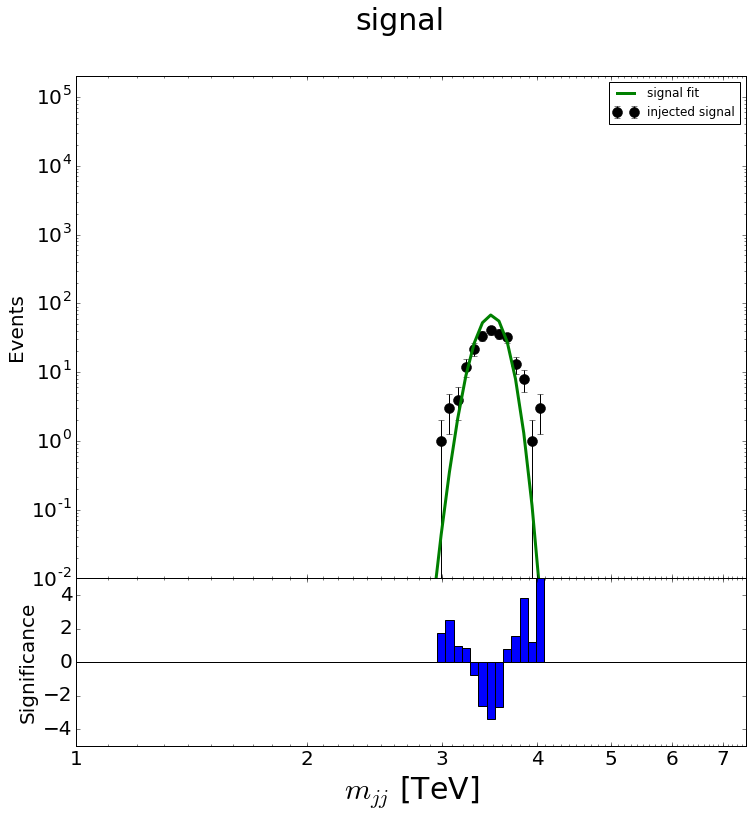

parameters (75, 4000, 250)
0
A, mass, tau 316.255453628 3904.6416458 363.139637905
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 78.2963410998
chi2 bkg+signal nan


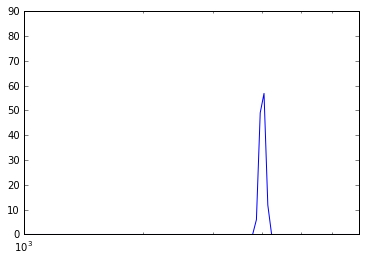

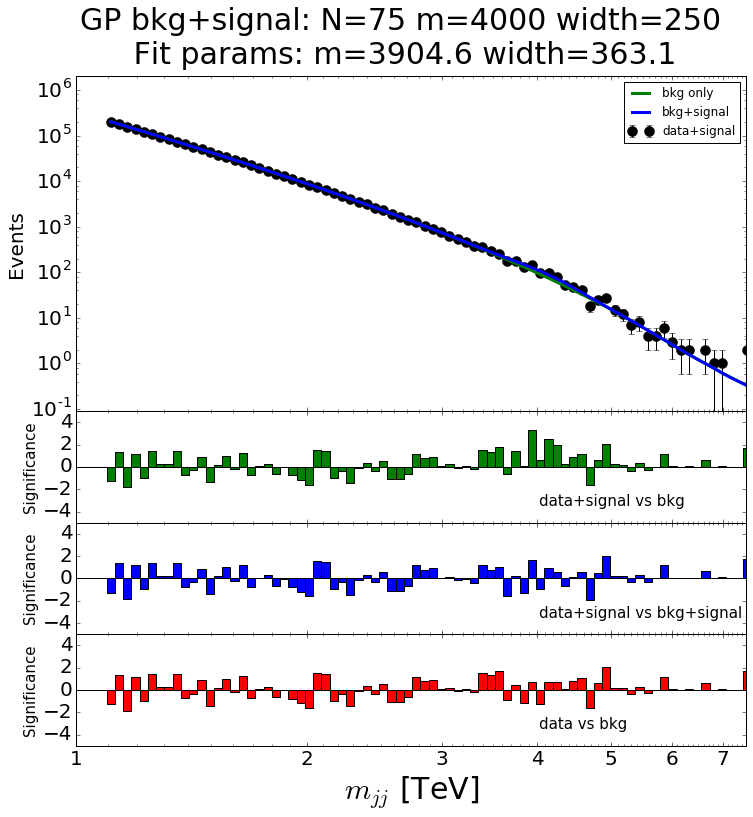

chi2 59.7384899748


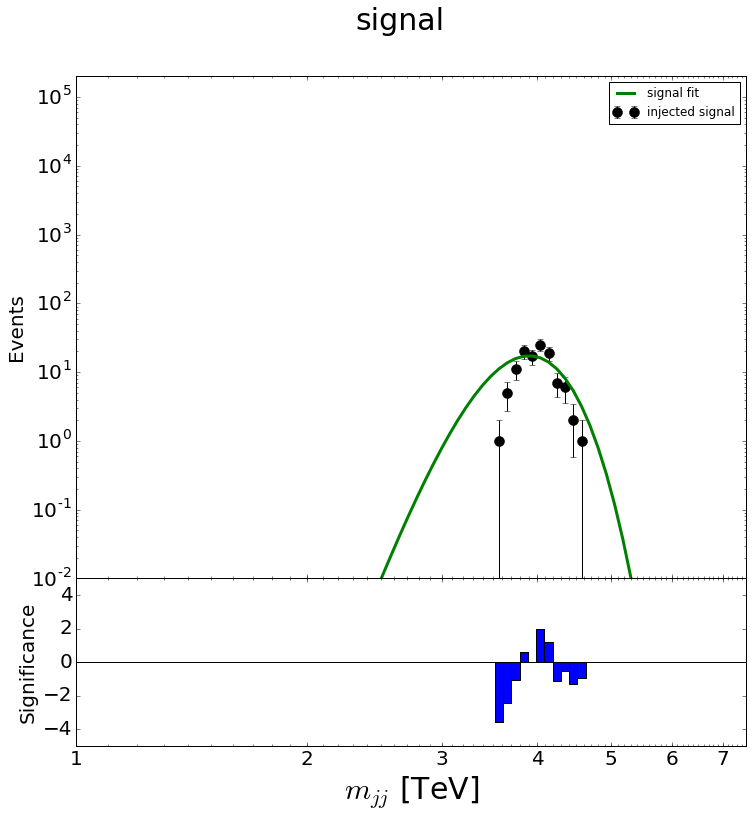

parameters (65, 4500, 250)
0
A, mass, tau 253.343261945 4467.67989629 243.48131814
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 78.4424933133
chi2 bkg+signal nan


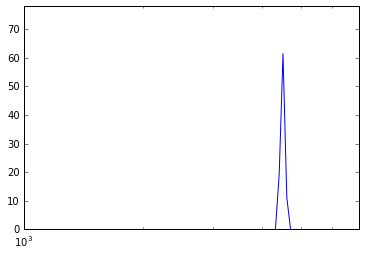

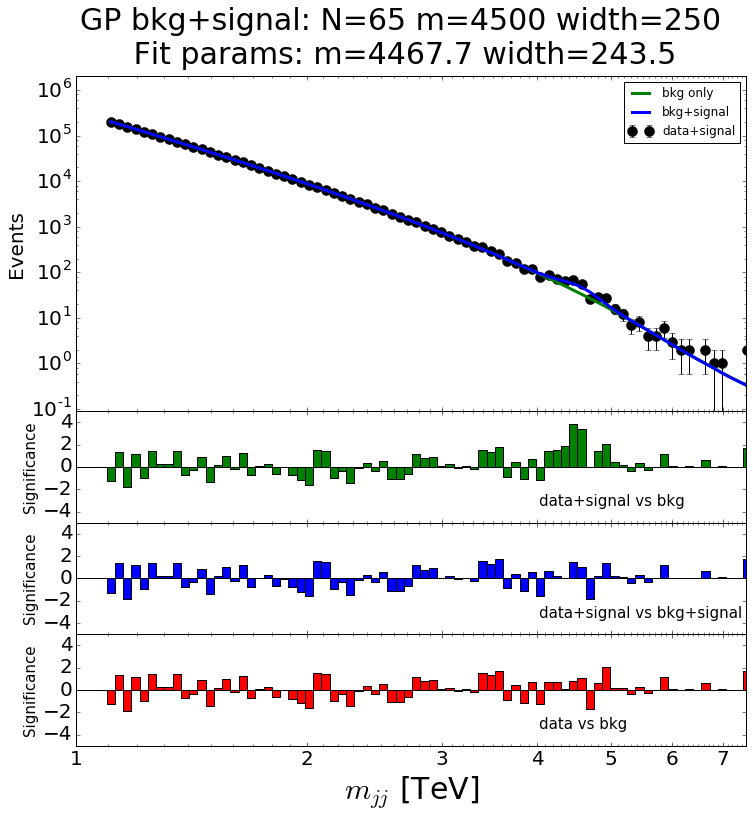

chi2 16.5749643005


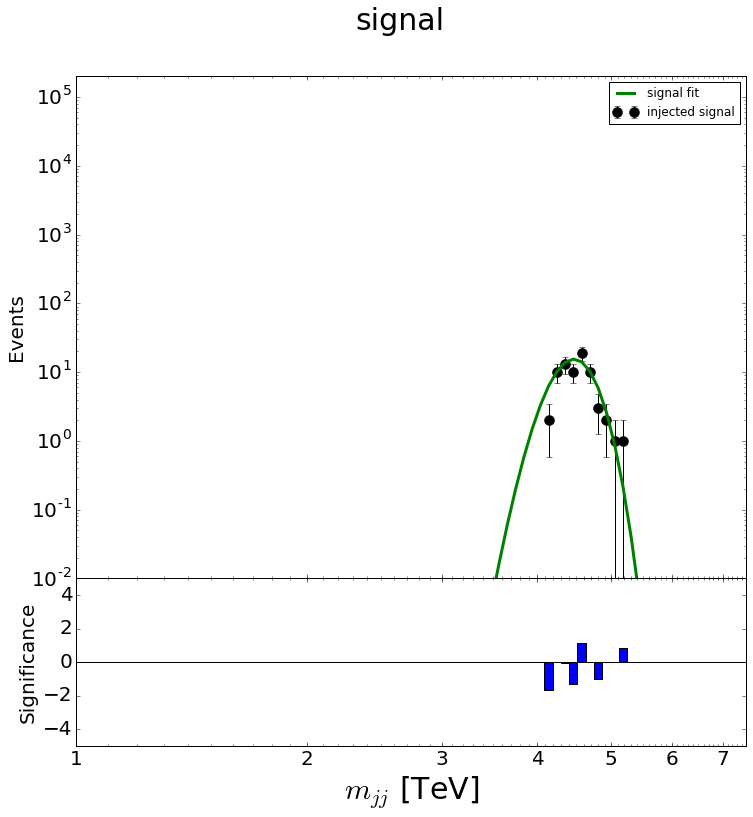

parameters (55, 5000, 250)
0
A, mass, tau 476.344487627 4968.36365072 118.486788498
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 77.9169297023
chi2 bkg+signal nan


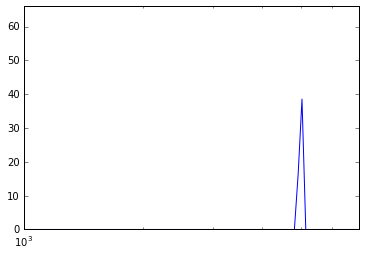

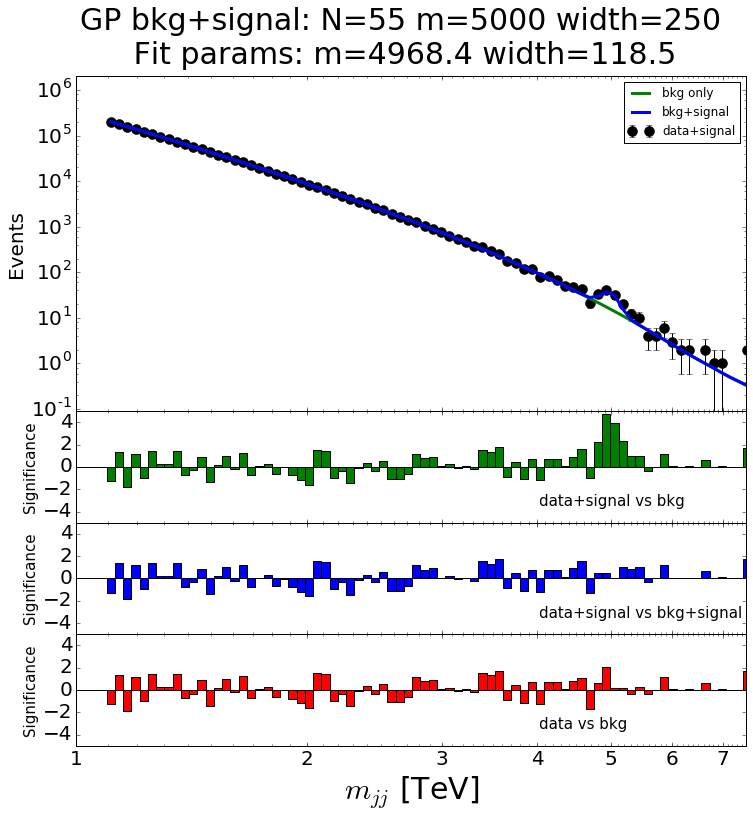

chi2 563.916406482


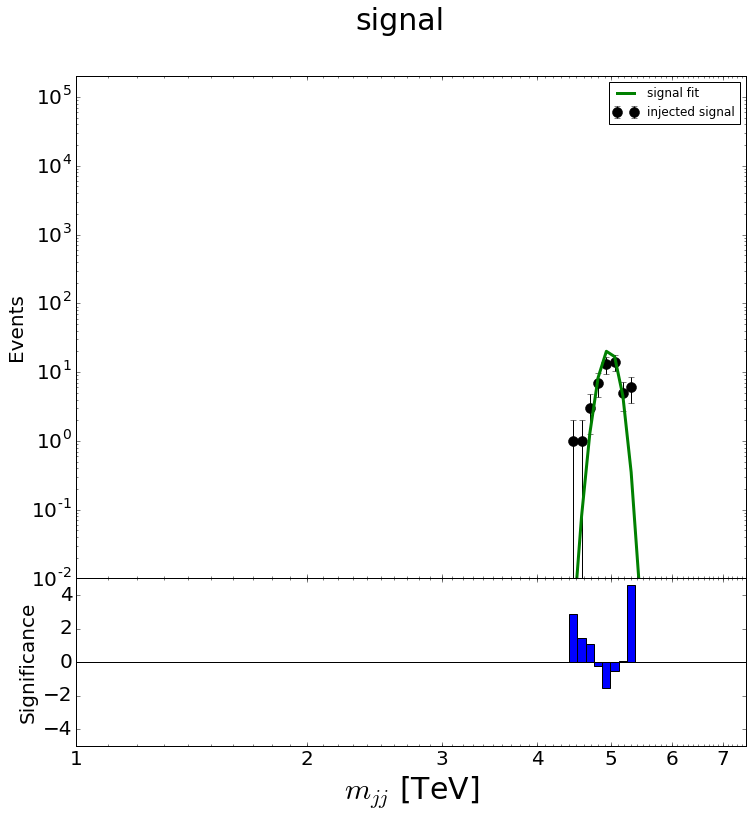

parameters (40, 5500, 250)
0
A, mass, tau 102.075293303 5468.20725769 271.602315975
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 77.106889652
chi2 bkg+signal nan


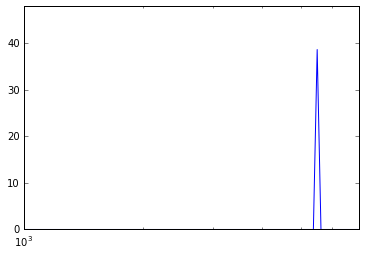

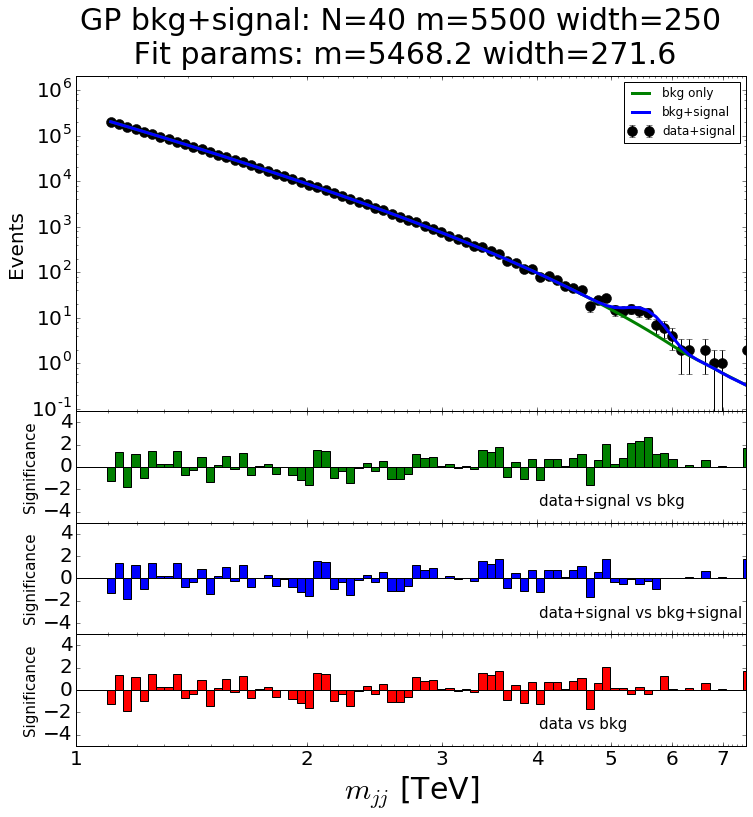

chi2 6.32088328918


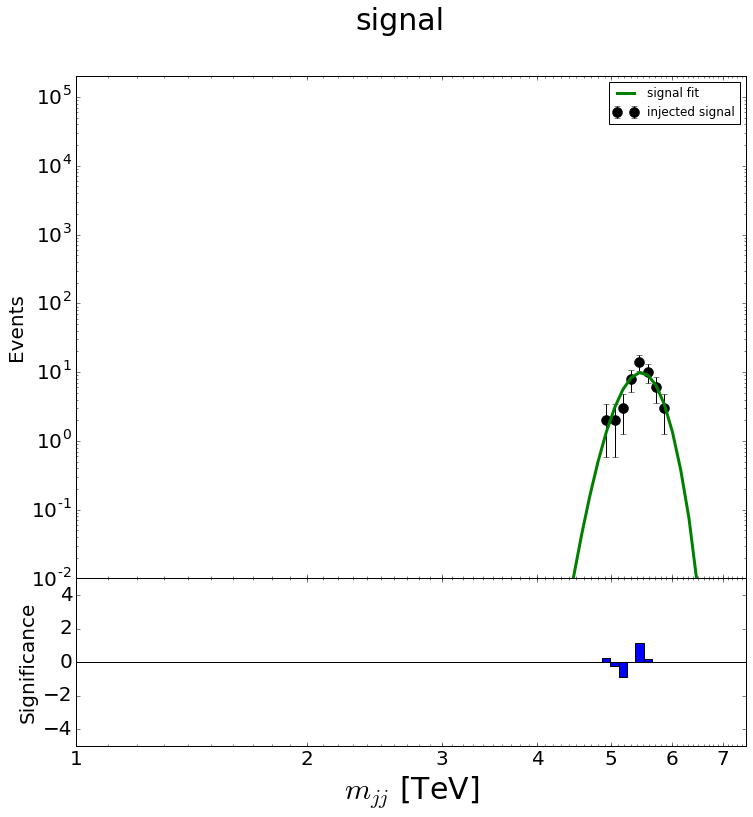

parameters (30, 6000, 250)
0
A, mass, tau 20.2257240335 6153.55694145 297.018499195


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 89.4867201808
chi2 bkg+signal nan


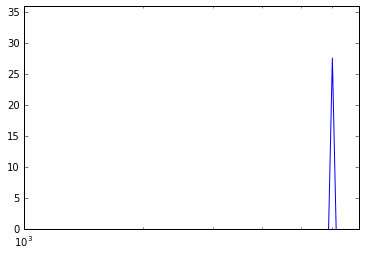

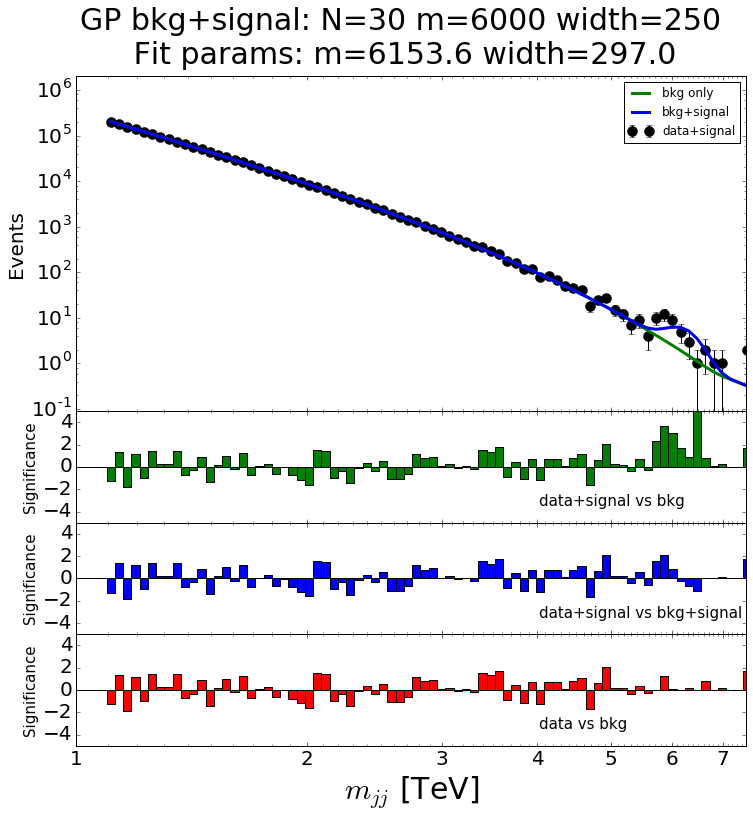

chi2 4.58060278374


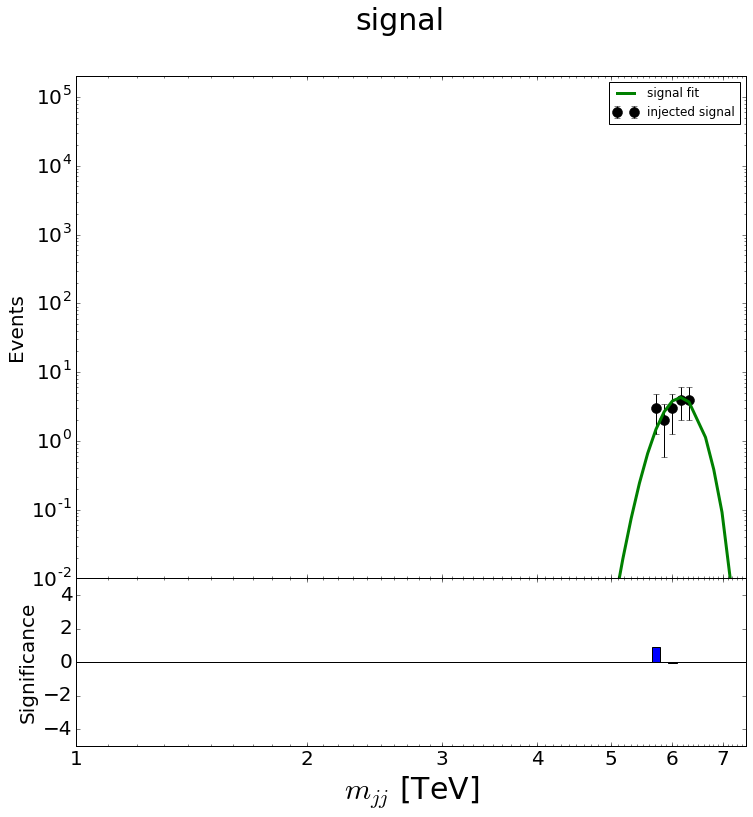

In [188]:
standardParamSets = [(300,2000,250), (200 ,2500, 250),(150, 3000, 250), (100, 3500, 250), (75, 4000, 250), 
             (65, 4500, 250), (55, 5000, 250), (40,5500, 250), (30, 6000,250)]

aa={}
mm={}
ww={}
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]
    for itoy, toy in enumerate(toyData[:1]): 
        if itoy%10 ==0: print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)
        smeared_counts, signalTemplate = smear(np.zeros(len(truth_steps)), signal, xtoy)
        smeared_countsO, signalTemplate_full = smear(np.zeros(len(truth_steps)), signal, xbins)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.xscale('log')
        plt.ylim([0, float(n)*1.2])
        
        
        ydata =  ytoy + signalTemplate
        ydata_full =  toy + signalTemplate_full
        
        Amp, lengthscale, p0, p1, p2 = fixedHyperparameters
        lnProb = logLike_gp_fitgpsig(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        
        hyperParams = fixedHyperparameters + best_fit_new
        MAP_GP, MAP_bkg, MAP_sig = runGP_SplusB(ydata, xtoy, xtoyerr, xbins, xerrs, hyperParams)
        
        newy, newx = addZeros(MAP_bkg, xtoy)
        

        label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
        makePrettyPlots_sb(xtoy, xbins, toy, ydata_full, newy, MAP_bkg, MAP_GP, binEdges, label)
        makePrettyPlots_signalOnly(xtoy, signalTemplate, MAP_sig, "signal")



### What about if you have a background estimation, but want to remove a bump in your data?
#### i.e. dijets normally run BumpHunter and remove the discrepant region if there is one. Or remove any spurious signal?
#### Just to test out, we'll run BumpHunter, and force our GP signal kernel to have a mean at the center of the BumpHunter interval

In [189]:
doDeficit = False
def BumpHunter(dataHist, bkgHist, minBins = 2, MinBinsInBump = 1, MaxBinsInBump = 1e5):
    ################
    if len(dataHist)!=len(bkgHist): print "check your inputs!"
    numBins = len(bkgHist)
    maxBins = len(bkgHist)/2
    firstBin = 0 
    lastBin = len(bkgHist) 
    nBins = len(bkgHist)
    for yi, y in reversed(list(enumerate(dataHist))):
        if y ==0:
            lastBin = yi-1
            break
    #####################
    mostInterestingP, lowEdgeMostInteresting, highEdgeMostInteresting = 1, 0, 0
    smallestPforWidth, lowEdgeForWidth, highEdgeForWidth = 1, 0, 0
    minBinL = 0
    maxBinL = 0
    #p-value in center
    probC = 1

    minWidth = max(MinBinsInBump,1);
    maxWidth = min(MaxBinsInBump,nBins/2);
            
    for width in range(minWidth, maxWidth+1, 1):
        minBinL = firstBin
        maxBinL = lastBin - width + 1

        nbinsinstep = 1#max(1,width/2)
        smallestPforWidth = 1
        lowEdgeForWidth = 0
        highEdgeForWidth = 0
        
        for binL in range(minBinL, maxBinL, nbinsinstep):
            binR = binL+width-1

            dC, bC= GetEffectiveBandContents(bkgHist, dataHist, binL, binR)

            if not doDeficit: 
                if dC <= bC: continue
                        
            probC = PoissonPval(dC,bC)

            if probC < smallestPforWidth and probC!=0:
                smallestPforWidth = probC
                lowEdgeForWidth = binEdges[binL]
                highEdgeForWidth = binEdges[binR] + xerrs[binR]
    
        if smallestPforWidth < mostInterestingP: 
            mostInterestingP = smallestPforWidth
            lowEdgeMostInteresting = lowEdgeForWidth
            highEdgeMostInteresting = highEdgeForWidth
    return -np.log(mostInterestingP), lowEdgeMostInteresting, highEdgeMostInteresting


def GetEffectiveBandContents(bkgHist, dataHist, firstBin, lastBin):
    dataIntegral, bkgIntegral = 0, 0
    for b in range(firstBin, lastBin+1, 1):
        dataIntegral += dataHist[b]
        bkgIntegral += bkgHist[b]
    return dataIntegral, bkgIntegral

def PoissonPval(data, bkg):
    answer = 1
    if data >= bkg:
        answer = ssp.gammainc(data,bkg)
    else:
        answer = 1. - ssp.gammainc(data+1,bkg)
    return answer


#### Same as above, but now we're not fitting for the mean of the GP signal, we're fixing it

In [190]:
Amp, length, p0, p1, p2 = fixedHyperparameters
lnProb = logLike_gp(xbins,ycounts, xerrs)
bestval, fixedHyperparameters = fit_gp_minuit(100, lnProb)


min LL 342.187773543
best fit vals (0.1, 99999.99982245038, 0.039330921216759185, 8.311780981429678, -5.231026374193153)


In [191]:
class logLike_gp_fitgpsig_BH:
    def __init__(self, x, y, xerr, mass):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.mass = mass
    def __call__(self, A, tau):
        Amp, lengthscale, p0, p1, p2 = fixedHyperparameters
        kernel_bkg = Kernel((Amp, lengthscale))
        kernel_sig = A * ExpSquaredCenteredKernel(m = self.mass, t = tau)
        kernel = kernel_bkg+kernel_sig
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_mean((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit_BH(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, tau = init1, error_A = 1., error_tau = 1., 
                   limit_A = (1, 5e3), limit_tau = (100, 400))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

parameters (4000, 2000, 250)
0
bump at 2197.45249916 1845.47131621 2549.43368211
min LL 360.535577057
best fit vals (4999.99999866562, 261.6542959435201)
A, tau 4999.99999867 261.654295944


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 80.3463835831
chi2 bkg+signal nan


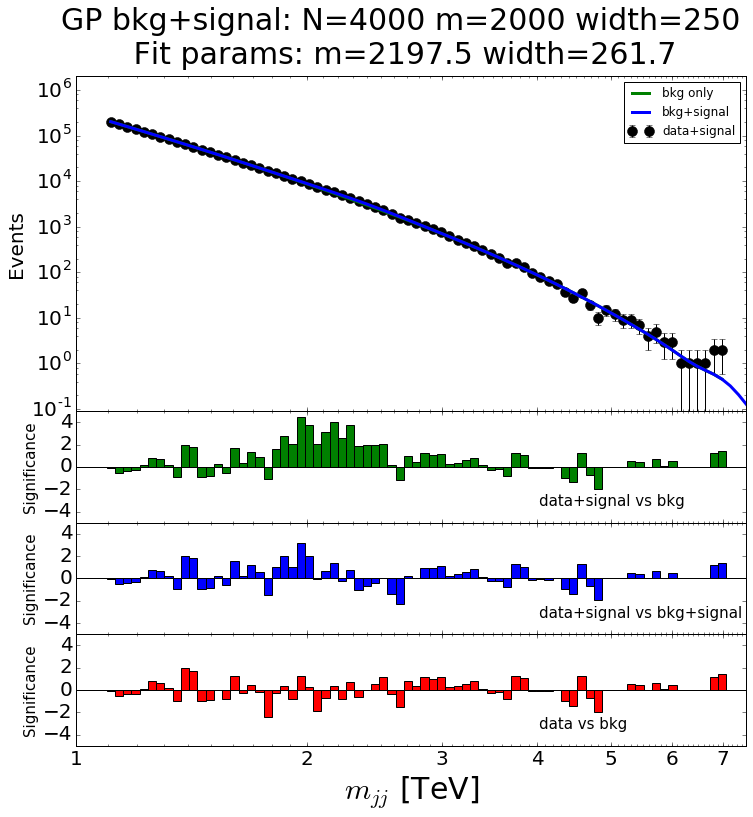

chi2 4379.58497057


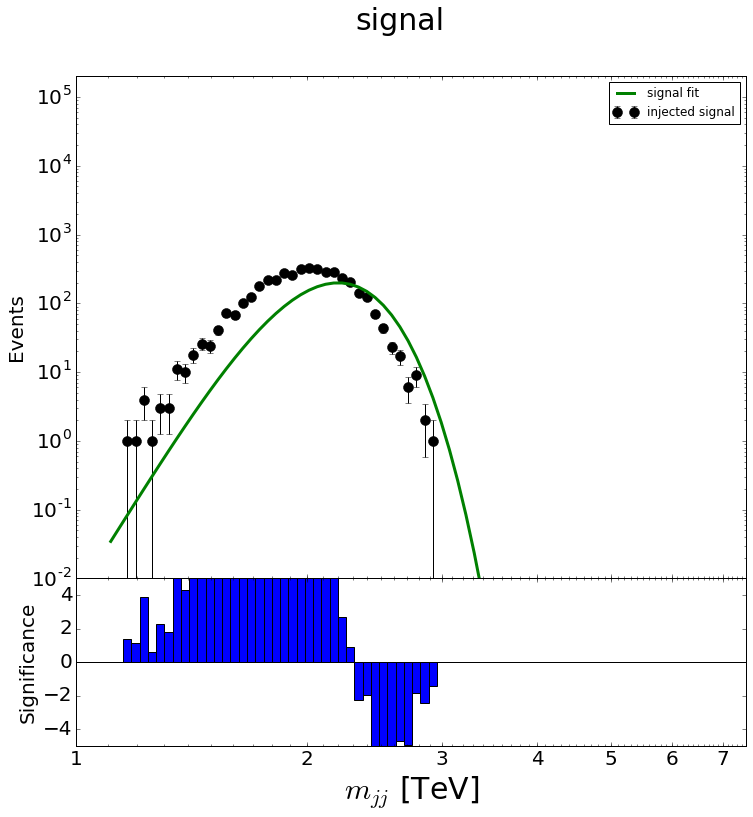

parameters (1500, 2500, 250)
0
bump at 2801.29997851 2251.48041319 3351.11954383
min LL 359.848140943
best fit vals (4999.999998311262, 269.61236724085916)
A, tau 4999.99999831 269.612367241
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 82.4708869468
chi2 bkg+signal nan


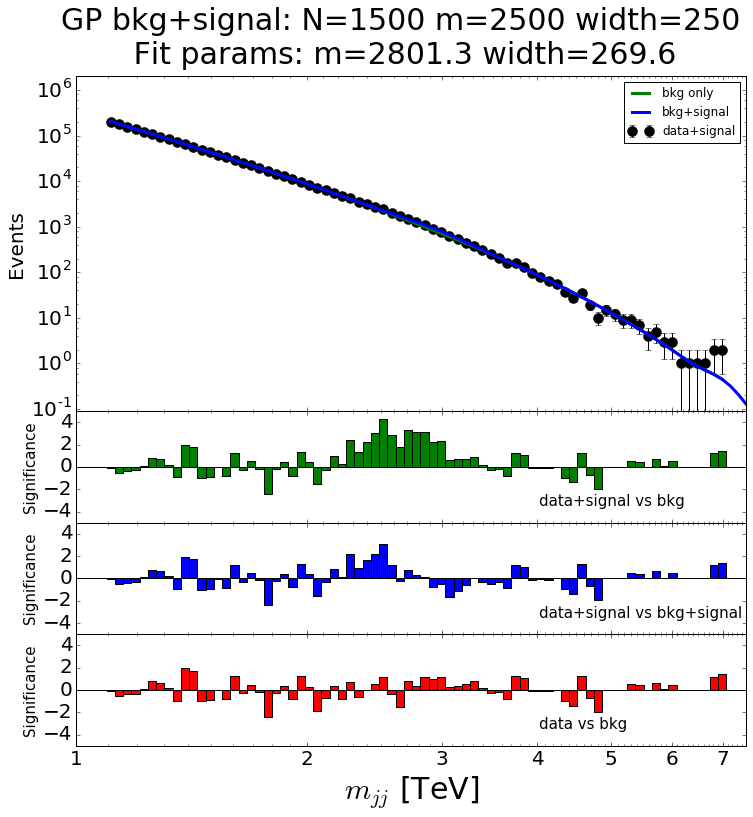

chi2 3692.23389592


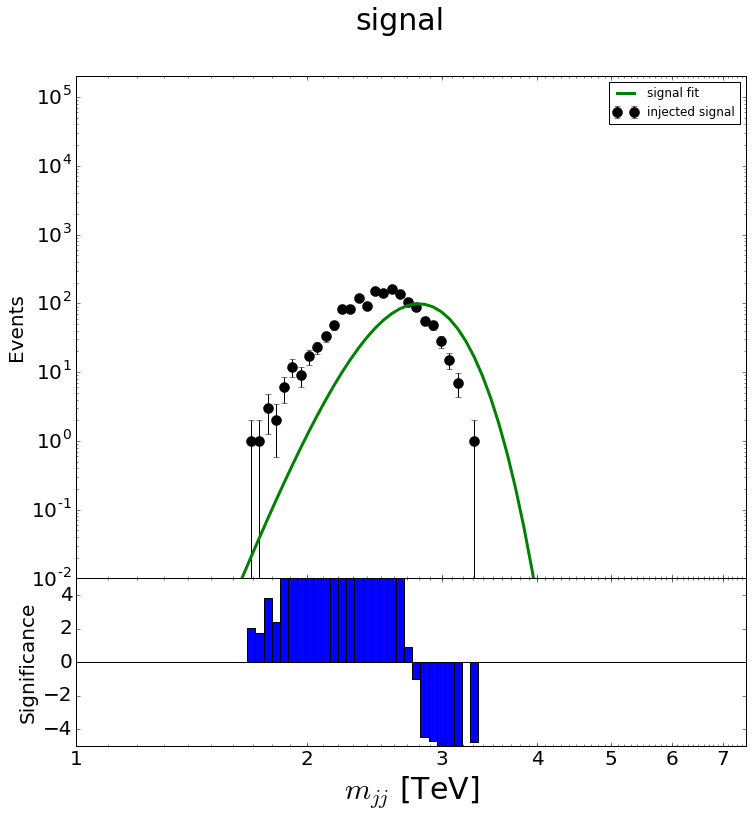

parameters (1000, 3000, 250)
0
bump at 3125.70298934 2815.94492238 3435.4610563
min LL 358.53895237
best fit vals (4999.999999749774, 229.99866446942758)
A, tau 4999.99999975 229.998664469
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 75.4798206314
chi2 bkg+signal nan


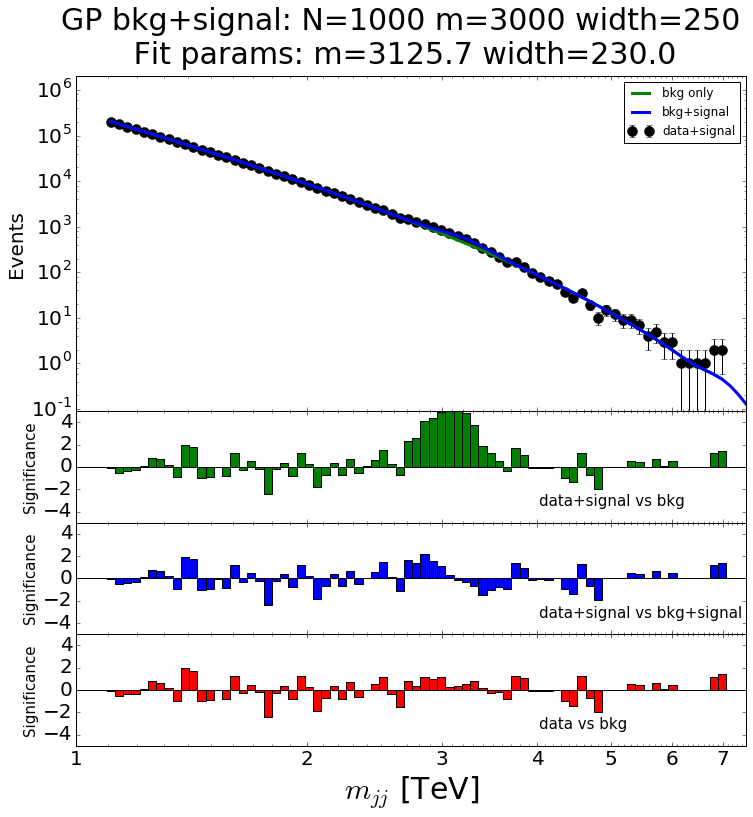

chi2 462.405975237


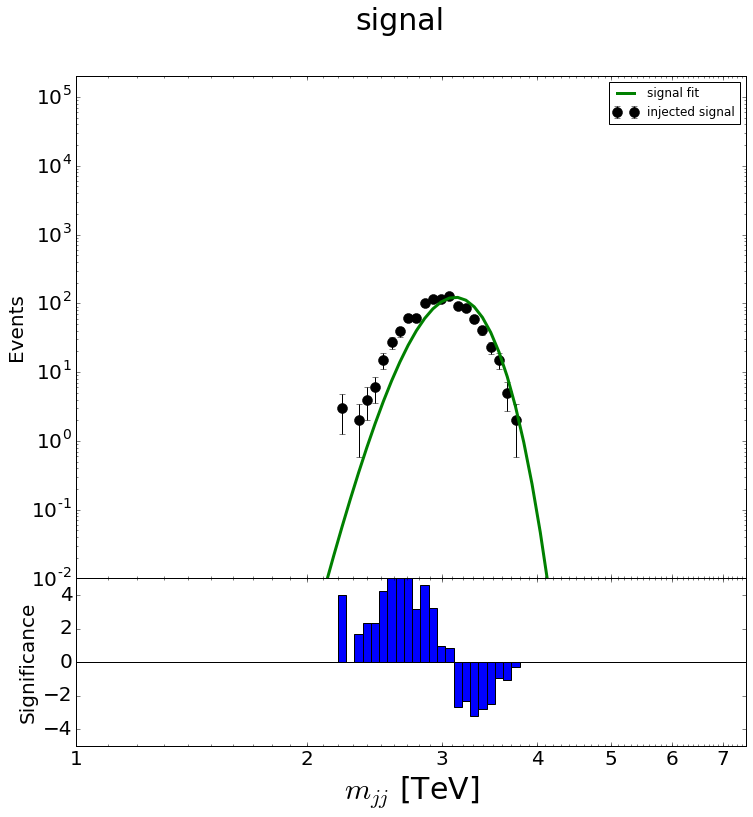

parameters (500, 3500, 250)
0
bump at 3638.48658469 3188.5975068 4088.37566257
min LL 359.891509603
best fit vals (4407.611326680677, 219.52890217241378)
A, tau 4407.61132668 219.528902172
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 75.942453923
chi2 bkg+signal nan


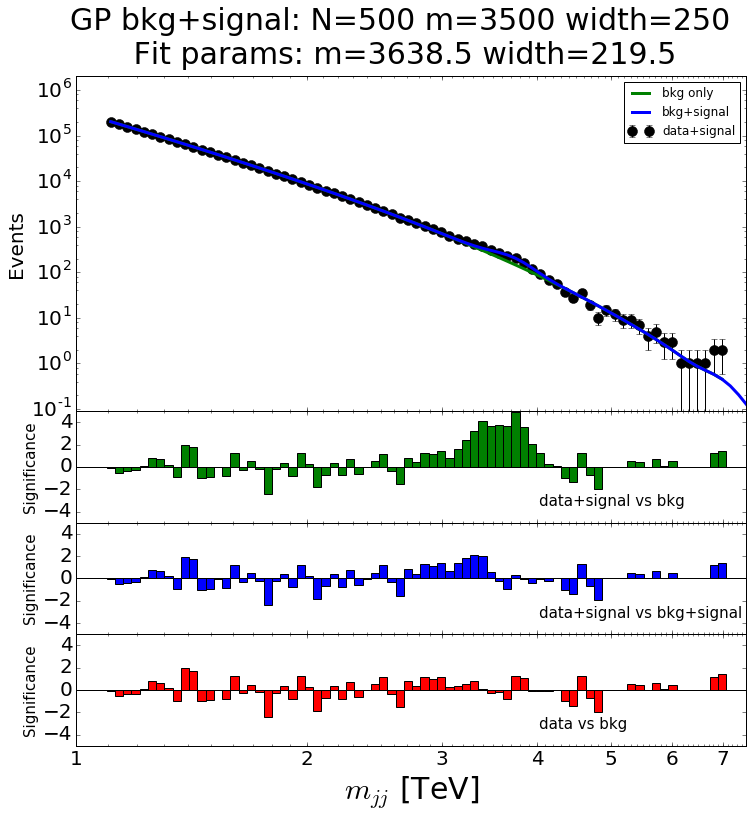

chi2 463.439133888


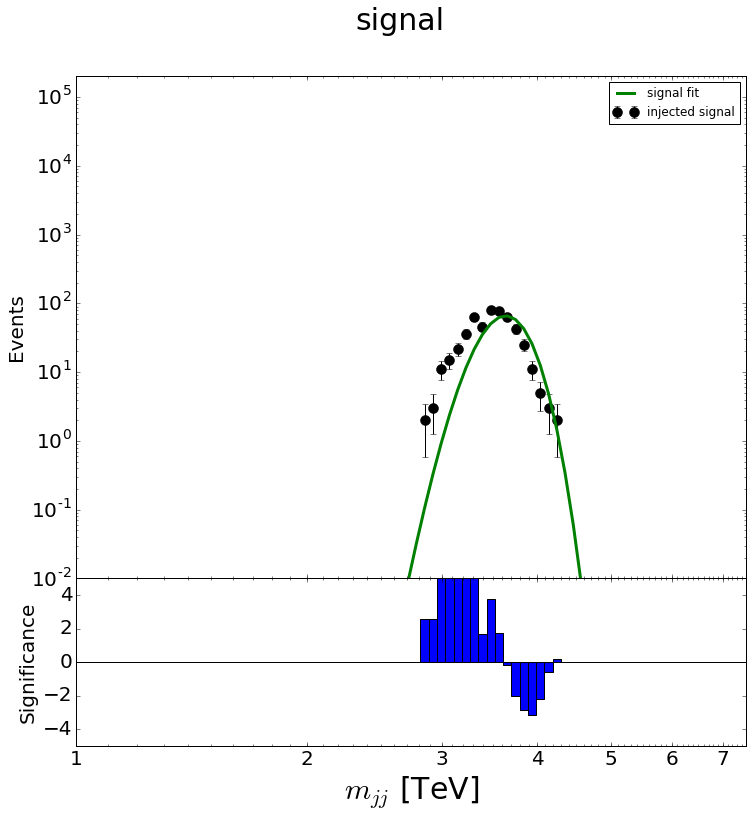

parameters (300, 4000, 250)
0
bump at 3999.09806746 3701.43696223 4296.7591727
min LL 351.070698607
best fit vals (2426.351150658487, 249.11321440264598)
A, tau 2426.35115066 249.113214403
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.6637441408
chi2 bkg+signal nan


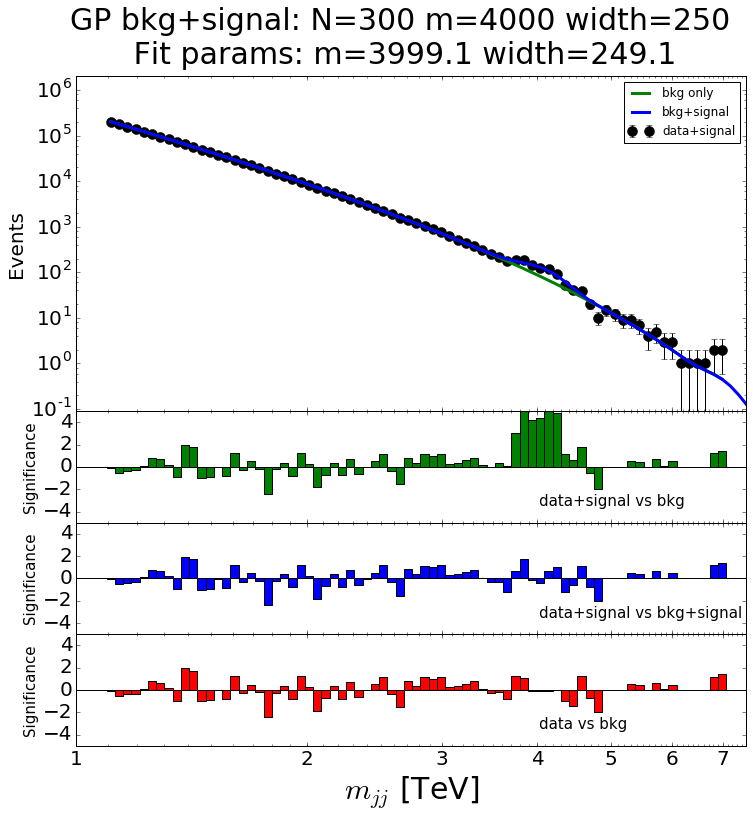

chi2 30.8431456368


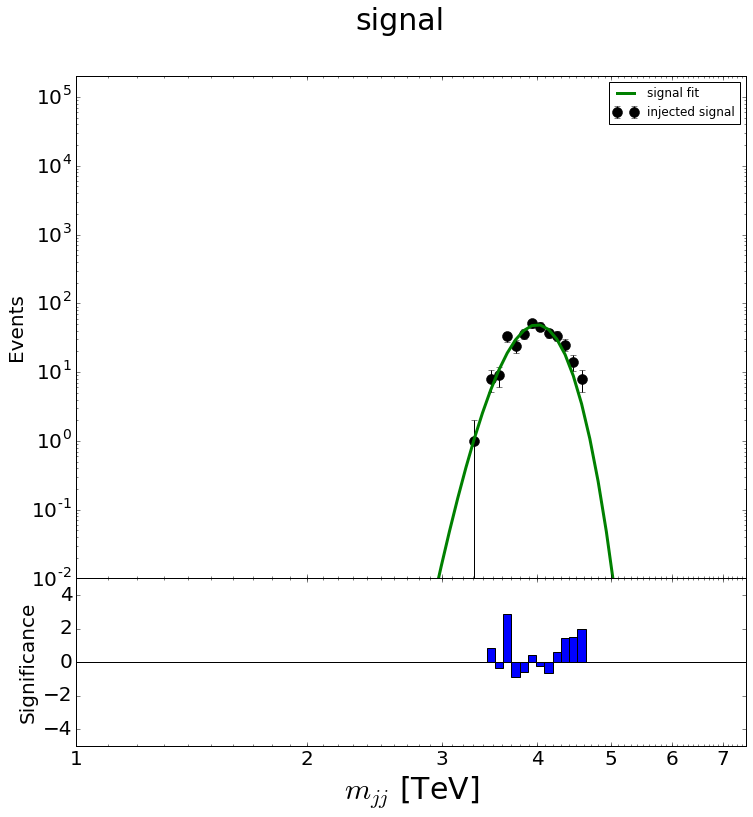

parameters (200, 4500, 250)
0
bump at 4521.34524926 4296.7591727 4745.93132582
min LL 350.345369541
best fit vals (1354.9126383497464, 233.89978581675595)
A, tau 1354.91263835 233.899785817
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 67.4050741457
chi2 bkg+signal nan


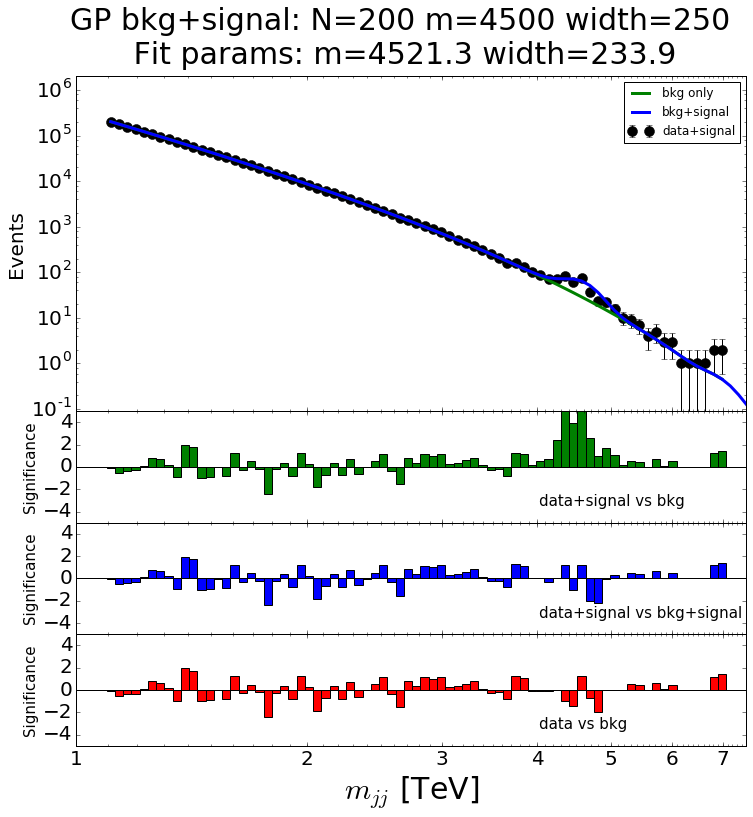

chi2 23.7162504255


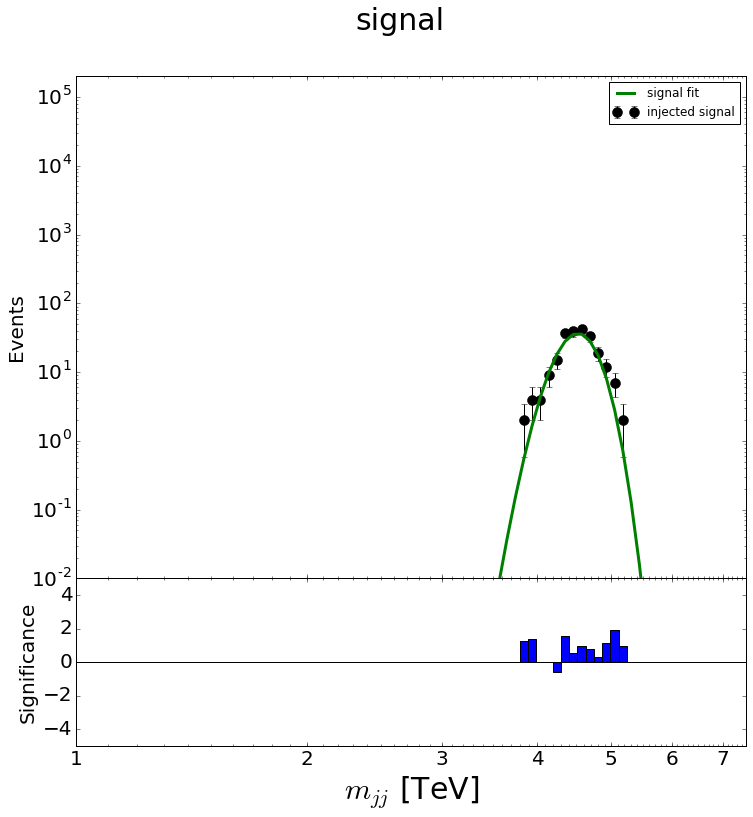

parameters (100, 5000, 250)
0
bump at 5187.31146102 4865.37768423 5509.24523781
min LL 352.224440633
best fit vals (373.73429170827535, 186.08268123599993)
A, tau 373.734291708 186.082681236
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.1895835843
chi2 bkg+signal nan


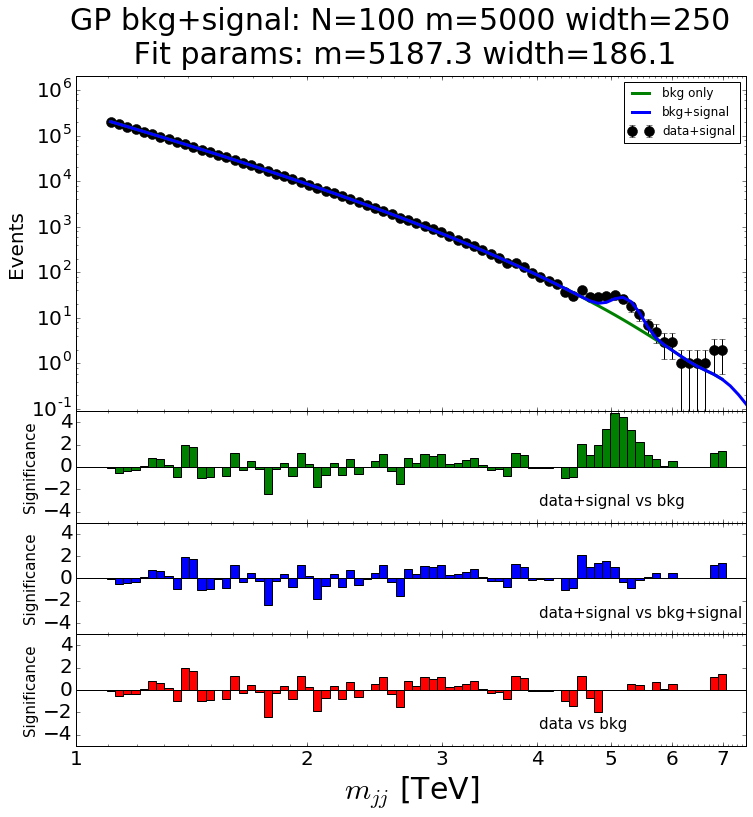

chi2 2558.14465719


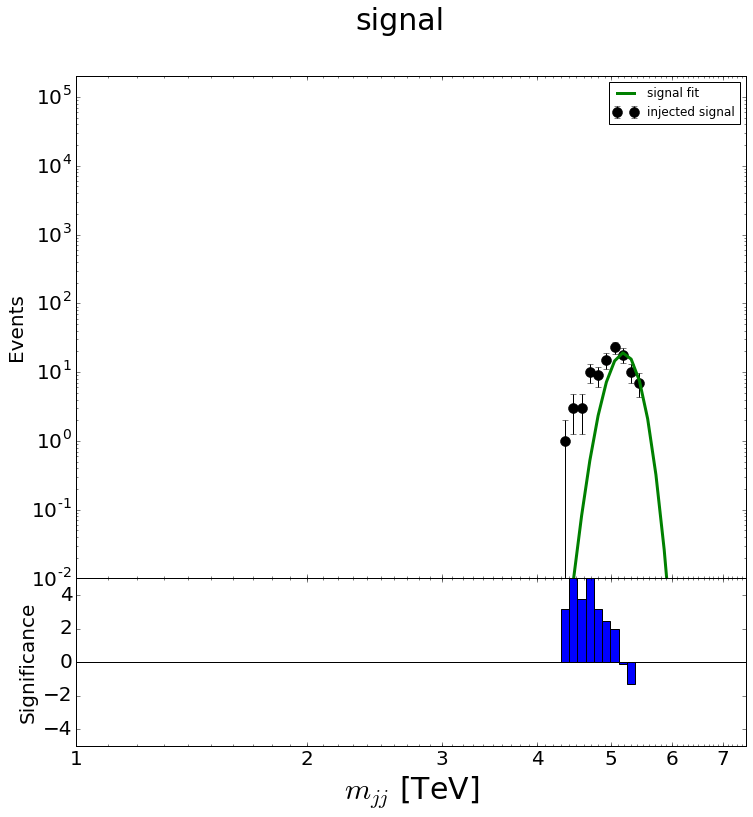

parameters (75, 5500, 250)
0
bump at 5663.6131732 5242.05878061 6085.1675658
min LL 364.272747805
best fit vals (202.66612305699064, 220.98492201022594)
A, tau 202.666123057 220.98492201
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 88.3050863118
chi2 bkg+signal nan


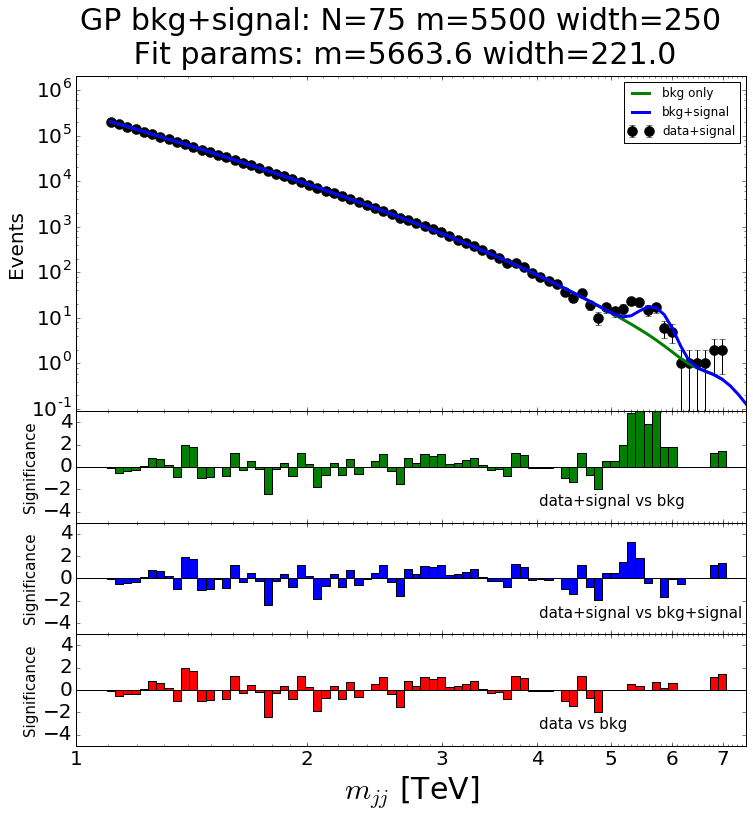

chi2 306.68102953


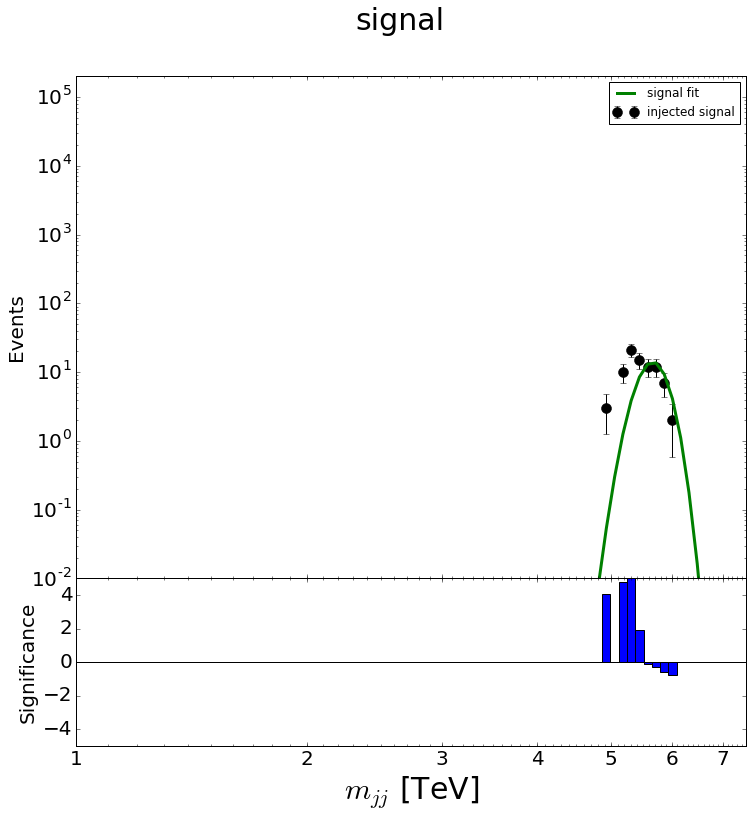

parameters (50, 6000, 250)
0
bump at 6286.56167697 5509.24523781 7063.87811613
min LL 364.257172585
best fit vals (25.674677032959046, 400.0)
A, tau 25.674677033 400.0
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 112.191581474
chi2 bkg+signal nan


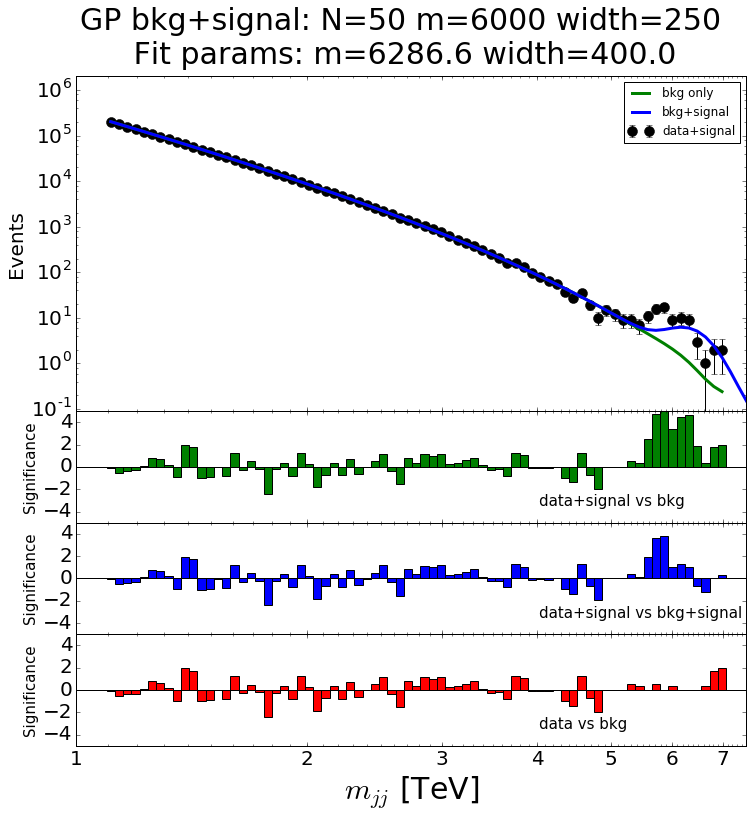

chi2 91.4975384687


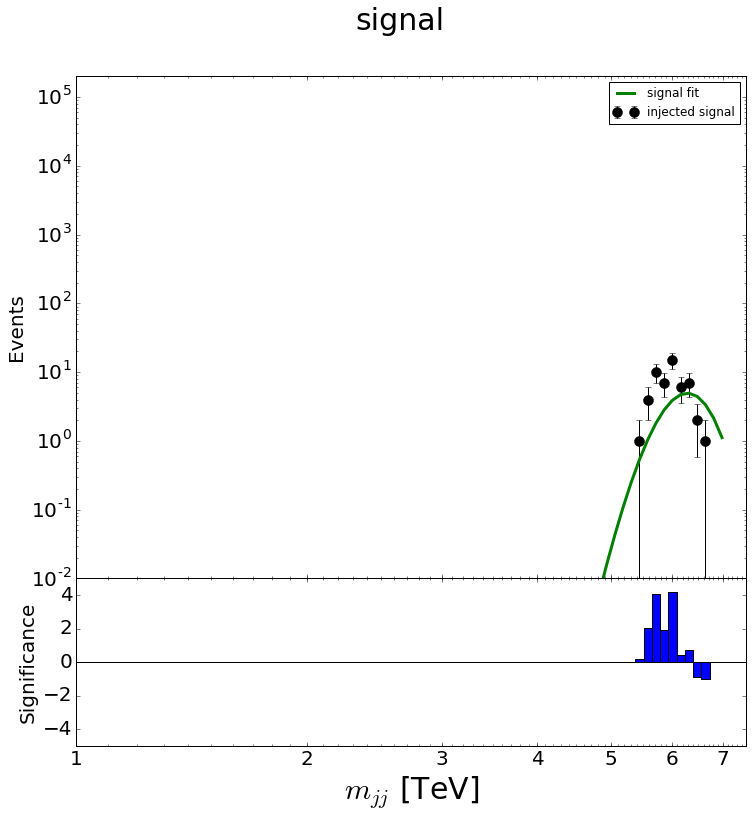

In [192]:
standardParamSets = [(4000,2000,250), (1500 ,2500, 250),(1000, 3000, 250), (500, 3500, 250), (300, 4000, 250), 
             (200, 4500, 250), (100, 5000, 250), (75,5500, 250), (50, 6000,250)] 

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    ww[m]=[]
    for itoy, toy in enumerate([ycounts]): 
        if itoy%10 ==0: print itoy

        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
        signalTemplate = np.random.poisson(np.around(signalTemplate))
        signalTemplate_full = sig_model(xbins, n, m, w, xerrs)
        signalTemplate_full = np.random.poisson(np.around(signalTemplate_full))
        
        ydata =  ytoy + signalTemplate
        ydata_full =  toy + signalTemplate_full
        
        MAP_GP_bOnly = runGP_Bonly(ydata, xtoy, xtoyerr, xbins, xerrs, fixedHyperparameters)

        
        BH, BHbinL, BHbinH = BumpHunter(ydata_full, MAP_GP_bOnly)
        print "bump at", BHbinH-(BHbinH-BHbinL)/2., BHbinL, BHbinH
        mass = BHbinH-(BHbinH-BHbinL)/2.
        
        Amp, lengthscale, p0, p1, p2 = fixedHyperparameters
        lnProb = logLike_gp_fitgpsig_BH(xtoy, ydata, xtoyerr, mass)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit_BH(lnProb, True)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, tau = best_fit_new 
        aa[m].append(A)
        ww[m].append(tau)
        print "A, tau", A, tau
        
        hyperParams = list(fixedHyperparameters) + [A, mass,tau]
        MAP_GP, MAP_bkg, MAP_sig = runGP_SplusB(ydata, xtoy, xtoyerr, xbins, xerrs, hyperParams)

        newy, newx = addZeros(MAP_bkg, xtoy)
        
        label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
        makePrettyPlots_sb(xtoy, xbins, toy, ydata_full, newy, MAP_bkg, MAP_GP, binEdges, label)
        makePrettyPlots_signalOnly(xtoy, signalTemplate, MAP_sig, "signal")

        